File: PMP_optimization.ipynb

Author: Pablo Javier Jimenez.

Email: pablojimenezcba@gmail.com

GitLab: https://gitlab.com/pablojimenezcba

Description: Quantum yield optimization program for radical pair model using Pontryagin Maximum Principle

# Imports ⚙️

In [278]:
%load_ext autoreload
%autoreload 2
import datetime
import os
import sys
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
sys.path.append('utils')
from utils.hamiltonian.kron import kron_
from utils.hamiltonian.hamiltonian import Hamiltonian
from utils.ode.schrodinger import H_ODE
from utils.ode.schrodinger_ini_guess import H_ODE as H_ODE_2
from utils.optimization.GPM import GPM
from utils.optimization.Gramm import Gramm
from utils.optimization.metrics import fraction_yield,quantum_yield,integrated_yield,ensemble_yields,J2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build Hamiltonian
Nuclear spin modules are set and Hamiltonian built

In [279]:
s = np.array([1/2,1/2,1/2,1/2])

H = Hamiltonian(s,diffusion=True,n_time=1000,t_tot=.5)#usually 1 us

H.k_S = 10./H.gamma_e
H.k_T = 10./H.gamma_e

# Build ensemble
1- Get nuclear and electron spin initial states for ensemble.

In [280]:
#Electron spin eigenstates
#singlet
psi_S = np.array([0.0, 1/np.sqrt(2), -1/np.sqrt(2), 0.0])[:, None]
#triplet
psi_T_plus = np.array([1.0, 0.0, 0.0, 0.0])[:, None]
psi_T_0 = np.array([0.0, 1.0/np.sqrt(2.0), 1.0/np.sqrt(2.0), 0.0])[:, None]
psi_T_minus = np.array([0.0, 0.0, 0.0, 1.])[:, None]

#Nuclear spins eigenstates. Uncloupled -> state i = (0....,1,0....) where 1 is in the i-th position
#Compressed in eye
psi_0_nuc = np.eye(H.Z)

2- Build radical pair initial states. Can be Singlet or Triplet born

In [281]:
if triplet:=True:
    psi_0 = [
        kron_((psi_T_plus, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]
    psi_0 += [
        kron_((psi_T_0, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]
    psi_0 += [
        kron_((psi_T_minus, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]
else:
    psi_0 = [
        kron_((psi_S, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]

# Set learning parameters
For hyperfine and/or field optimization

In [282]:
#ODE solver (forward and backward)
ode = H_ODE(H)
ode_2 = H_ODE_2(H)
#initial field
bounds_u = (-6.e-3,-3.e-3)
bounds_A = (-0.6,-0.3)

field = np.ones((H.n_time, 3))*([bounds_u[1],bounds_u[1],bounds_u[1]])
H.omega_t = field.copy()

"""
filename = '1P_MAX_T_1e-05_500.mat'
mat = scipy.io.loadmat('data_jose/%s'%filename)
u_ =mat['sol_PMP'][0][0][-1][0][0][0][0][0].T
A_ =mat['sol_PMP'][0][0][-1][0][0][1][0][0].T

#field_2 = mat['sol_PMP'][0][0][5][0][0][0][0][0].T
#A_ = mat['sol_PMP'][0][0][5][0][0][1][0][0].T

H.A[:,0,0,0] = A_[:,0].copy()
H.A[:,0,1,1] = A_[:,1].copy()
H.A[:,0,2,2] = A_[:,2].copy()

H.omega_t = u_.copy()
"""
H.A[:,0,0,0] = -0.234
H.A[:,0,1,1] = -0.234
H.A[:,0,2,2] =  0.117

#initial values
initial_f_y,initial_i_y,initial_q_y,_ = ensemble_yields(psi_0,ode,H,method='rk4',build_Ht=True)
initial_u = H.omega_t.copy()
#regularization
th = 0
tol= 0#1.e-5
#GPM
gpm = GPM(H,ode,psi_0)


## Grammian matrix optimization

In [ ]:
from quantum.quantum_operations import bra_ket
from utils.ode.methods import shooting
from time import time

ode.set_y(psi_0[0])
ode.solve_forward(method='rk4',build_Ht=True)
ode.solve_backward(method='rk4')
aux = ode.w_t.copy()

def f(x):
    ode.w_t[0] = x
    ode.solve_forward_chi(method='rk4')
    return ode.w_t.copy()


def to_time():
    ode.set_y(psi_0[0])
    ode.w_t=shooting(f,[psi_0[0],ode.w_t[0]+np.random.rand(8)/100])

def g_to_time():
    ode.solve_sensitivity_chi('rk4')
    ode.set_y(psi_0[0])
    ode.solve_forward(method='rk4',build_Ht=True)
    ode.w_t[0] = np.ones(ode.w_t[0].shape)/np.sqrt(ode.w_t[0].shape[0])

    while np.linalg.norm(ode.w_t[-1])>1e-4:
        ode.solve_forward_chi(method='rk4')
        print((ode.w_t[-1].conj().dot(ode.w_t[-1])).real)
        P = -ode.U_t[-1].dot(ode.w_t[-1])
        A = ode.U_t[-1].dot(ode.U_t[-1])
        ode.w_t[0] += np.linalg.solve(A,P)


to_time()

fig=plt.figure()
#plt.plot([-10],[0],color='red')
#plt.plot([-10],[0],color='black',linestyle='--')
plt.legend(['backward','forward + Gram'])
plt.plot(H.t/H.gamma_e,ode.w_t.real,color='red',alpha=0.6)
plt.plot(H.t/H.gamma_e,aux.real,color='black',linestyle='--')
plt.ylabel(r'Re[$\chi$]')
plt.xlabel(r't [$\mu$s]')
plt.xlim([0,14.1])

print(ode.w_t[0])
#optimization
#print('Initial:',initial_q_y)
#print('---------------')
#J_g,f_y_g,i_y_g = gramm.field_optimization(50,1.e-4,tol,bounds=bounds,maximize=triplet)


## Hyperfine optimization

In [ ]:
print('Initial:',initial_q_y)
print('---------------')
epochs = [50000,50000,10000,40000,100000]
#try using time dependent learning rate
lr = 2.e4

#H.A = np.load('A_1p_hyperfine_optimization.npy')

"""
filename = 'SOL_M2_500ns_new.dat'
mat = scipy.io.loadmat(filename)
A_ = mat['SOL_M2_s'][0][0][4][0][1][0][0].T
H.A[:,0,0,0] = A_[:,0,0].copy()
H.A[:,0,1,1] = A_[:,0,1].copy()
H.A[:,0,2,2] = A_[:,0,2].copy()
"""
J_gpm0,f_y_gpm,i_y_gpm,g_gpm0 = gpm.hyperfine_optimization(lr,0.,epochs[0],tol,update_lr=0,bounds=bounds_A,maximize=True,check_bvp=00)
A_gpm0 = H.A.copy()
J_gpm1,f_y_gpm,i_y_gpm,g_gpm1 = gpm.hyperfine_optimization(lr,0.,epochs[1],tol,update_lr=0,bounds=bounds_A,maximize=True,check_bvp=00)
A_gpm1 = H.A.copy()
J_gpm2,f_y_gpm,i_y_gpm,g_gpm2 = gpm.hyperfine_optimization(lr,0.,epochs[2],tol,update_lr=0,bounds=bounds_A,maximize=True,check_bvp=00)
A_gpm2 = H.A.copy()
J_gpm3,f_y_gpm,i_y_gpm,g_gpm3 = gpm.hyperfine_optimization(lr,0.,epochs[3],tol,update_lr=0,bounds=bounds_A,maximize=True,check_bvp=00)
A_gpm3 = H.A.copy()
J_gpm4,f_y_gpm,i_y_gpm,g_gpm4 = gpm.hyperfine_optimization(lr,0.,epochs[4],tol,update_lr=0,bounds=bounds_A,maximize=True,check_bvp=00)
u_gpm4 = H.omega_t.copy()
A_gpm4 = H.A.copy()

J_gpm = np.concatenate((J_gpm0[:-1],J_gpm1[:-1],J_gpm2[:-1],J_gpm3[:-1],J_gpm4[:-1]))

J_bb,f_y_b,i_y_bb,g_bb = gpm.hyperfine_optimization(5.e9,0.,1,tol,update_lr=0,bounds=bounds_A,maximize=True,check_bvp=10)
u_bb = H.omega_t.copy()
A_bb = H.A.copy()
print('J_bb',J_bb[-1])


## New method

In [ ]:
print('Initial:',initial_q_y)
print('---------------')
#try using time dependent learning rate
lr = 2.e23

H.A[:,0,0,0]= -0.234#bounds_A[1]
H.A[:,0,1,1]= -0.234#bounds_A[1]
H.A[:,0,2,2]= 0.117 #bounds_A[1]
H.omega_t = np.ones((H.n_time, 3))*([bounds_u[0],bounds_u[0],bounds_u[0]])

#J_gpm,f_y_gpm,i_y_gpm,g_gpm = gpm.field_optimization(lr,0.,11,1.e-10,1000,update_lr=0,bounds=bounds_u,maximize=True,check_bvp=300)
#u_gpm=H.omega_t.copy()

J_gpm,f_y_gpm,i_y_gpm,g_gpm = gpm.hyperfine_optimization(lr,0.,11,tol,100,update_lr=0,bounds=bounds_A,maximize=True,check_bvp=300)

"""
Js=[]
us=[]
for time_limit in range(10,500,10):
    H.omega_t = np.ones((H.n_time, 3))*([bounds_u[1],bounds_u[1],bounds_u[1]])

    J_gpm,f_y_gpm,i_y_gpm,g_gpm = gpm.field_optimization(lr,0.,,tol,time_limit,update_lr=0,bounds=bounds_u,maximize=True,check_bvp=300)
    us.append(H.omega_t.copy())
    Js.append(J_gpm)
    print('---------------')
    print(time_limit)
    print('---------------')
"""

## Simultaneous optimization

In [ ]:
from quantum.quantum_operations import bra_ket
print('Initial:',initial_q_y)
print('---------------')
#epochs = [5,5,10,30,50]
epochs = [500,500,10000,40000,50000]
#try using time dependent learning rate
ode.set_y(psi_0[0])
ode.solve_forward(method='rk4',build_Ht=True)
lr = np.array([5.e1,5.e2])


H.A = np.load('A_1p_simultaneous_optimization.npy')
H.omega_t = np.load('u_1p_simultaneous_optimization.npy')
"""
pmp = '2P_MAX_T_1e-05_500.mat'
pmp = scipy.io.loadmat(pmp)
A_pmp = pmp['sol_PMP'][0][0][-1][0][0][1][0][0].T
u_pmp = pmp['sol_PMP'][0][0][-1][0][0][0][0][0].T
#calculate parameters
for i in range(3):
    H.A[:,0,i,i] = A_pmp[0,:,i]
    H.A[:,1,i,i] = A_pmp[1,:,i]
H.omega_t = u_pmp.copy()
"""

"""
filename = 'SOL_M2_500ns_new.dat'
mat = scipy.io.loadmat(filename)
A_ = mat['SOL_M2_s'][0][0][4][0][1][0][0].T
u_ = mat['SOL_M2_s'][0][0][4][0][0][0][0].T
H.A[:,0,0,0] = A_[:,0,0].copy()
H.A[:,0,1,1] = A_[:,0,1].copy()
H.A[:,0,2,2] = A_[:,0,2].copy()
H.omega_t = u_[:,0]
#_=gpm.optimization(lr,(0.,0.),epochs[0],tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True,check_bvp=0)
"""
J_gpm0,f_y_gpm,i_y_gpm,g_gpm0,gpm_A0 = gpm.optimization(lr,(0.,0.),epochs[0],tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True,check_bvp=0)
u_gpm0 = H.omega_t.copy()
A_gpm0 = H.A.copy()
J_gpm1,f_y_gpm,i_y_gpm,g_gpm1,gpm_A1 = gpm.optimization(lr,(0.,0.),epochs[1],tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True,check_bvp=0)
u_gpm1 = H.omega_t.copy()
A_gpm1 = H.A.copy()
J_gpm2,f_y_gpm,i_y_gpm,g_gpm2,gpm_A2 = gpm.optimization(lr,(0.,0.),epochs[2],tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True,check_bvp=0)
u_gpm2 = H.omega_t.copy()
A_gpm2 = H.A.copy()
J_gpm3,f_y_gpm,i_y_gpm,g_gpm3,gpm_A3 = gpm.optimization(lr,(0.,0.),epochs[3],tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True,check_bvp=0)
u_gpm3 = H.omega_t.copy()
A_gpm3 = H.A.copy()
J_gpm4,f_y_gpm,i_y_gpm,g_gpm4,gpm_A4 = gpm.optimization(lr,(0.,0.),epochs[4],tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True,check_bvp=0)
u_gpm4 = H.omega_t.copy()
A_gpm4 = H.A.copy()

J_gpm = np.concatenate((J_gpm0[:-1],J_gpm1[:-1],J_gpm2[:-1],J_gpm3[:-1],J_gpm4[:-1]))

J_bb,f_y_b,i_y_bb,g_bb,gpm_A_bb = gpm.optimization((5.e9,5.e9),(0.,0.),1,tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)
u_bb = H.omega_t.copy()
A_bb = H.A.copy()
print('J_bb',J_bb[-1])


## Field optimization

In [44]:
print('Initial:',initial_q_y)
print('---------------')
epochs = [10,10,10,10,10]
#try using time dependent learning rate
ode.set_y(psi_0[0])
ode.solve_forward(method='rk4',build_Ht=True)

#path = 'results/1P/Field/[-6,-3]_14us' #FIELD 1P14us
#filename_pmp = 'solution_14us_2000_JOSE.mat' #FIELD 1P 14us

# -------------------------------- pmp results ------------------------------- #
#load controls
"""
pmp = os.path.join(path,'DATA/results_PMP',filename_pmp)
pmp = scipy.io.loadmat(pmp)
A_pmp = pmp['sol'][0][0][-1][0][0][1][0][0].T#[::2]
gA_pmp_ = -pmp['sol'][0][0][-1][0][0][1][0][1].T#[::2]
gA_pmp = np.ones(H.A.shape)
gA_pmp[:,0,0,0] = gA_pmp_[:,0]
gA_pmp[:,0,1,1] = gA_pmp_[:,1]
gA_pmp[:,0,2,2] = gA_pmp_[:,2]

u_pmp = pmp['sol'][0][0][-1][0][0][0][0][0].T#[::2]
gu_pmp = -pmp['sol'][0][0][-1][0][0][0][0][1].T#[::2]

for i in range(3):
    H.A[:,0,i,i] = A_pmp[:,i]
H.omega_t = u_pmp.copy()
"""

lr = 5.e5
J_gpm0,f_y_gpm,i_y_gpm,g_gpm0 = gpm.field_optimization(lr,0.,epochs[0],tol,update_lr=0,bounds=bounds_u,maximize=True)
u_gpm0 = H.omega_t.copy()
A_gpm0 = H.A.copy()
J_gpm1,f_y_gpm,i_y_gpm,g_gpm1 = gpm.field_optimization(lr,0.,epochs[1],tol,update_lr=0,bounds=bounds_u,maximize=True)
u_gpm1 = H.omega_t.copy()
A_gpm1 = H.A.copy()
J_gpm2,f_y_gpm,i_y_gpm,g_gpm2 = gpm.field_optimization(lr,0.,epochs[2],tol,update_lr=0,bounds=bounds_u,maximize=True)
u_gpm2 = H.omega_t.copy()
A_gpm2 = H.A.copy()
J_gpm3,f_y_gpm,i_y_gpm,g_gpm3 = gpm.field_optimization(lr,0.,epochs[3],tol,update_lr=0,bounds=bounds_u,maximize=True)
u_gpm3 = H.omega_t.copy()
A_gpm3 = H.A.copy()
J_gpm4,f_y_gpm,i_y_gpm,g_gpm4 = gpm.field_optimization(lr,0.,epochs[4],tol,update_lr=0,bounds=bounds_u,maximize=True)
u_gpm4 = H.omega_t.copy()
A_gpm4 = H.A.copy()

J_gpm = np.concatenate((J_gpm0[:-1],J_gpm1[:-1],J_gpm2[:-1],J_gpm3[:-1],J_gpm4[:-1]))
#
#J_bb,f_y_b,i_y_bb,g_bb = gpm.field_optimization(5.e9,0.,1,tol,update_lr=0,bounds=bounds_u,maximize=True)
#u_bb = H.omega_t.copy()
#A_bb = H.A.copy()
#print('J_bb',J_bb[-1])

Initial: 0.028847919690584235
---------------
Epoch: 0/10, J: 2.88606031e-02, J2: 2.88606031e-02,d_x0: 9.1769e+05, Time: 10:15
Epoch: 0/10, J: 2.88610292e-02, J2: 2.88610292e-02,d_x0: 9.1768e+05, Time: 10:16
Epoch: 0/10, J: 2.88610292e-02, J2: 2.88610292e-02,d_x0: 9.1768e+05, Time: 10:16
Epoch: 0/10, J: 2.88610292e-02, J2: 2.88610292e-02,d_x0: 9.1768e+05, Time: 10:16
Epoch: 0/10, J: 2.88610292e-02, J2: 2.88610292e-02,d_x0: 9.1768e+05, Time: 10:16


## Linear connection between results

In [32]:
print('Initial:',initial_q_y)
print('---------------')
epochs = [100,100,300,1000,10000]
#try using time dependent learning rate
#ode.set_y(psi_0[0])
#ode.solve_forward(method='rk4',build_Ht=True)
lr = 1.e16

#J_gpm0,f_y_gpm,i_y_gpm,g_gpm0 = gpm.field_optimization(lr,0.,epochs[0],tol,update_lr=0,bounds=bounds_u,maximize=True,check_bvp=0)
#u_gpm0 = H.omega_t.copy()
#J_gpm1,f_y_gpm,i_y_gpm,g_gpm1 = gpm.field_optimization(lr,0.,epochs[1],tol,update_lr=0,bounds=bounds_u,maximize=True,check_bvp=0)
#u_gpm1 = H.omega_t.copy()
#J_gpm2,f_y_gpm,i_y_gpm,g_gpm2 = gpm.field_optimization(lr,0.,epochs[2],tol,update_lr=0,bounds=bounds_u,maximize=True,check_bvp=0)
#u_gpm2 = H.omega_t.copy()
#J_gpm3,f_y_gpm,i_y_gpm,g_gpm3 = gpm.field_optimization(lr,0.,epochs[3],tol,update_lr=0,bounds=bounds_u,maximize=True,check_bvp=0)
#u_gpm3 = H.omega_t.copy()
J_gpm4,f_y_gpm,i_y_gpm,g_gpm4 = gpm.field_optimization(lr,0.,epochs[4],tol,update_lr=0,bounds=bounds_u,maximize=True,check_bvp=0)
u_gpm4 = H.omega_t.copy()
A_gpm4 = H.A.copy()

#J_gpm = np.concatenate((J_gpm0[:-1],J_gpm1[:-1],J_gpm2[:-1],J_gpm3[:-1],J_gpm4[:-1]))
J_gpm = J_gpm4

J_bb,f_y_b,i_y_bb,g_bb = gpm.field_optimization(5.e9,0.,1,tol,update_lr=0,bounds=bounds_u,maximize=True)
u_bb = H.omega_t.copy()
A_bb = H.A.copy()
print('J_bb',J_bb[-1])

Initial: 0.0288609636984962
---------------
Epoch: 0/10000, J: 3.72377456e-02, J2: 3.72377456e-02,d_x0: 1.0526e+06, Time: 9:38
Epoch: 10/10000, J: 3.72377652e-02, J2: 3.72377652e-02,d_x0: 1.6154e-07, Time: 9:38
Epoch: 20/10000, J: 3.72377652e-02, J2: 3.72377652e-02,d_x0: 1.6212e-07, Time: 9:38
Epoch: 30/10000, J: 3.72377652e-02, J2: 3.72377652e-02,d_x0: 1.6299e-07, Time: 9:38
Epoch: 40/10000, J: 3.72377651e-02, J2: 3.72377651e-02,d_x0: 1.6386e-07, Time: 9:38
Epoch: 50/10000, J: 3.72377651e-02, J2: 3.72377651e-02,d_x0: 1.6474e-07, Time: 9:38
Epoch: 60/10000, J: 3.72377651e-02, J2: 3.72377651e-02,d_x0: 1.6564e-07, Time: 9:38
Epoch: 70/10000, J: 3.72377651e-02, J2: 3.72377651e-02,d_x0: 1.6652e-07, Time: 9:39
Epoch: 80/10000, J: 3.72377651e-02, J2: 3.72377651e-02,d_x0: 1.6742e-07, Time: 9:39
Epoch: 90/10000, J: 3.72377651e-02, J2: 3.72377651e-02,d_x0: 1.6833e-07, Time: 9:39
Epoch: 100/10000, J: 3.72377651e-02, J2: 3.72377651e-02,d_x0: 1.6924e-07, Time: 9:39
Epoch: 110/10000, J: 3.72377651e

KeyboardInterrupt: 

## Save

In [201]:
H.A = A_gpm4.copy()
H.omega_t = u_gpm4.copy()

es = len(psi_0)
ws = len(psi_0[0])


if save_wave:=True:
    wave = np.zeros((H.n_time,ws*es*4))
    for i,psi_ in enumerate(psi_0):
        ode.set_y(psi_)
        ode.solve_forward(method='rk4',build_Ht=True)
        ode.solve_backward(method='rk4')
        wave[:,ws*i:ws*(i+1)] = ode.y_t.real
        wave[:,ws*es+(ws*i):ws*es+(ws*(i+1))] = ode.y_t.imag
        wave[:,2*ws*es+(ws*i):2*ws*es+(ws*(i+1))] = ode.w_t.real
        wave[:,3*ws*es+(ws*i):3*ws*es+(ws*(i+1))] = ode.w_t.imag

    np.savetxt('wave_1p_A_optimization_.dat',wave)
    np.save('A_1p_A_optimization_.npy',H.A)
    np.save('u_1p_A_optimization_.npy',H.omega_t)


## Quick plot

In [ ]:
if load_data:=False:
    A__ = np.load('data4jose/_A_1p_simultaneous_optimization.npy')
    u__ = np.load('data4jose/_u_1p_simultaneous_optimization.npy')
    filename = 'data_jose/1P_MAX_T_1e-06_1000.mat'
    mat = scipy.io.loadmat(filename)
    u_ =  mat['sol_PMP'][0][0][7][0][0][0][0][0].T[::2]
    A_ = H.A*0
    aux = mat['sol_PMP'][0][0][7][0][0][1][0][0].T
    A_[:,0,0,0] = aux[::2,0]
    A_[:,0,1,1] = aux[::2,1]
    A_[:,0,2,2] = aux[::2,2]
else:
    A_ = A_gpm0.copy()
    u_ = u_gpm0.copy()

H.A = A_.copy()
H.omega_t = u_.copy()

#_=gpm.hyperfine_optimization(5.e9,0.,1,tol,update_lr=0,bounds=bounds_A,maximize=True)

#H.A[1600:,0,0,0] = -0.3
#H.A[:300,0,1,1] = -0.3
#H.A[1600:,0,2,2] = -0.6


#_,_,_,g_A=gpm.hyperfine_optimization(5.e-11,0.,1,tol,update_lr=0,bounds=bounds_A,maximize=True)
#H.A[H.A>-.45]=-0.3
#H.A[H.A<-.45]=-0.6

#H.omega_t[H.omega_t>-.0045]=-0.003
#H.omega_t[H.omega_t<-.0045]=-0.006

#_,_,_,g_u,g_A=gpm.optimization((5.e11,5.e11),(0.,0.),1,tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)
_,_,_,g_u,g_A=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)
#J_bb,f_y_b,i_y_bb,g_u = gpm.field_optimization(5.e11,0.,1,tol,update_lr=0,bounds=bounds_u,maximize=True)
#J_bb,f_y_b,i_y_bb,g_u2= gpm.field_optimization(5.e-11,0.,1,tol,update_lr=0,bounds=bounds_u,maximize=True)

fig = plt.figure(figsize=(14,6))
fig2 = plt.figure(figsize=(14,6))
fig3 = plt.figure(figsize=(14,6))
fig4 = plt.figure(figsize=(14,6))
for i in range(3):
    ax=fig.add_subplot(3,1,i+1)
    ax2=fig2.add_subplot(3,1,i+1)
    ax3=fig3.add_subplot(3,1,i+1)
    ax4=fig4.add_subplot(3,1,i+1)
    #ax.plot(H.t/H.gamma_e,A__[:,0,i,i],color='black')
    ax.plot(H.t/H.gamma_e,H.A[:,0,i,i],color='red',alpha=0.6)
    ax2.plot(H.t/H.gamma_e,g_A[:,0,i,i],color='red')
    ax2.axhline(0.,color='black',linestyle='--')
    #ax3.plot(H.t/H.gamma_e,u__[:,i]*1.e3,color='black')
    ax3.plot(H.t/H.gamma_e,u_gpm0[:,i]*1.e3,color='red',alpha=0.6)
    ax4.plot(H.t/H.gamma_e,g_u[:,i],color='red')
    ax4.axhline(0.,color='black',linestyle='--')

    #ax.set_xlim((0,1.05))
    #ax2.set_xlim((0,1.05))
    #ax3.set_xlim((0,1.05))
    #ax4.set_xlim((0,1.05))

## Switching times optimization
Get switch locations

In [ ]:
A_peaks = np.copy(H.A)
u_peaks = np.copy(u_gpm)

if A_switches:=False:
    s = [np.where(abs(np.diff(A_peaks[:,0,i,i]))>0.15)[0] for i in range(3)]
    rs = [A_peaks[s[i][0],0,i,i]>-0.45 for i in range(3)]
    l0 = np.zeros((np.max([len(s[i]) for i in range(3)])+2,3))
    for i in range(3):
        c1 = int(rs[i])
        l0[c1:len(s[i])+c1,i] = H.t[s[i]]
        if c1:
            l0[0,i] = -100
        l0[len(s[i])+c1:,i] = 1000

if u_switchs:=True:
    s = [np.where(abs(np.diff(u_peaks[:,i]))>1.5e-3)[0] for i in range(3)]
    rs = [u_peaks[s[i][0],i]>-4.5e-3 for i in range(3)]
    l0_u = np.zeros((np.max([len(s[i]) for i in range(3)])+2,3))
    for i in range(3):
        c1 = int(rs[i])
        l0_u[c1:len(s[i])+c1,i] = H.t[s[i]]
        if c1:
            l0_u[0,i] = -100
        l0_u[len(s[i])+c1:,i] = 1000

Optimize switching times

In [ ]:
from utils.optimization.GPM_peaks import GPM as GPM_peaks

gpm_p = GPM_peaks(H,ode,psi_0)
gpm_p.t0 = l0.copy()
#gpm_p.t0_u = l0_u.copy()

_=gpm_p.hyperfine_optimization(5.e2,0.,5000,tol,update_lr=0,bounds=bounds_A,maximize=True)
#_=gpm_p.field_optimization(5.e3,0.,1000,tol,update_lr=0,bounds=bounds_u,maximize=True)

#_=gpm_p.optimization((5.e1,1.e2),2500,tol,bounds=(bounds_u,bounds_A),maximize=True)

A_inf = H.A.copy()
u_inf = H.omega_t.copy()
u_inf_aux = H.omega_t.copy()
A_inf_aux = H.A.copy()
#plt.plot(H.t/H.gamma_e,H.A[:,0,0,0],color='red',alpha=0.6)

## Cosine optimization
Calculate Fourier transform of the control

In [ ]:
from scipy.fft import fft, fftfreq

# Number of sample points
N = len(H.t)
# sample spacing
T = H.t[1]-H.t[0]
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(A_gpm4[:,0,0,0])
xf = fftfreq(N, T)[:N//2]
plt.figure(figsize=(14,6))
plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
q = xf[np.argmax(2.0/N * np.abs(yf[1:N//2]))+2]

Optimize oscilant control

In [ ]:
from utils.optimization.GPM_cosine import GPM as GPM_cosine

H.A = A_gpm4.copy()

gpm_c = GPM_cosine(H,ode,psi_0)

gpm_c.w = [0.44]*3
gpm_c.phi = [0]*3
gpm_c.c = [0.4]*3

_=gpm_c.hyperfine_optimization(1.e-2,0.,1000,tol,update_lr=0,bounds=bounds_A,maximize=True)

## Plot all results: GPM, GPM_infty, PMP
Controls

Epoch: 0/1, J: 4.47683309e-02, J2: 4.47683309e-02,d_x0: 4.0229e+05, Time: 15:52


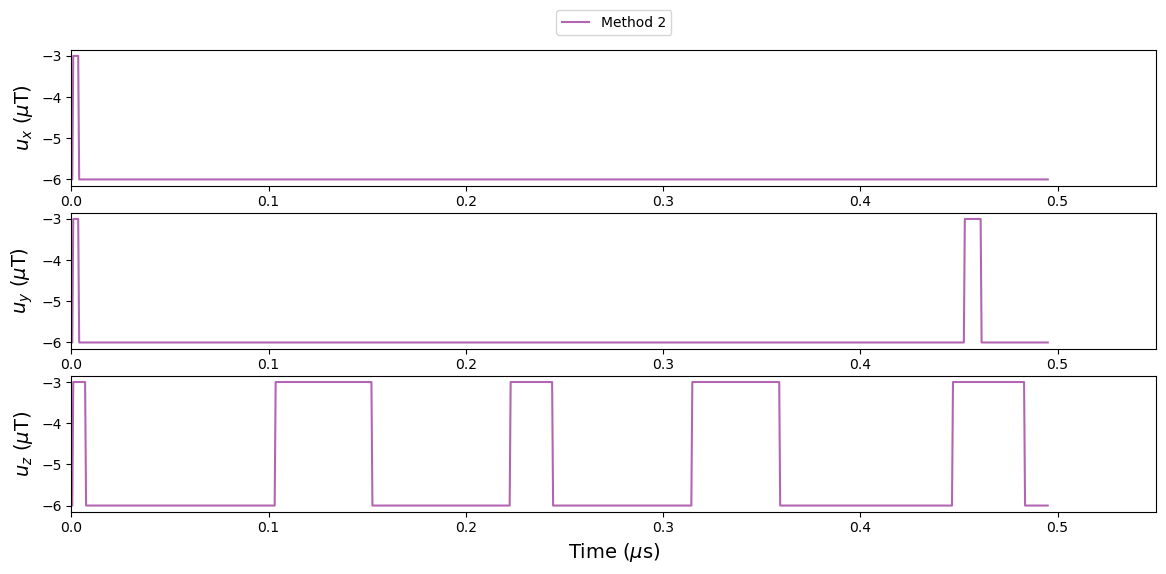

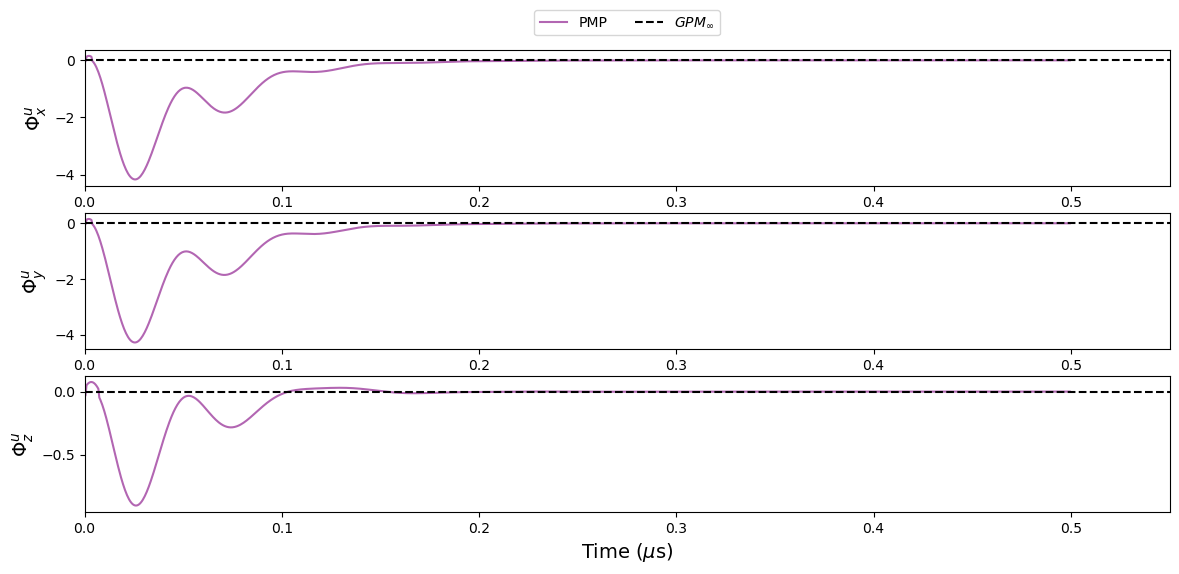

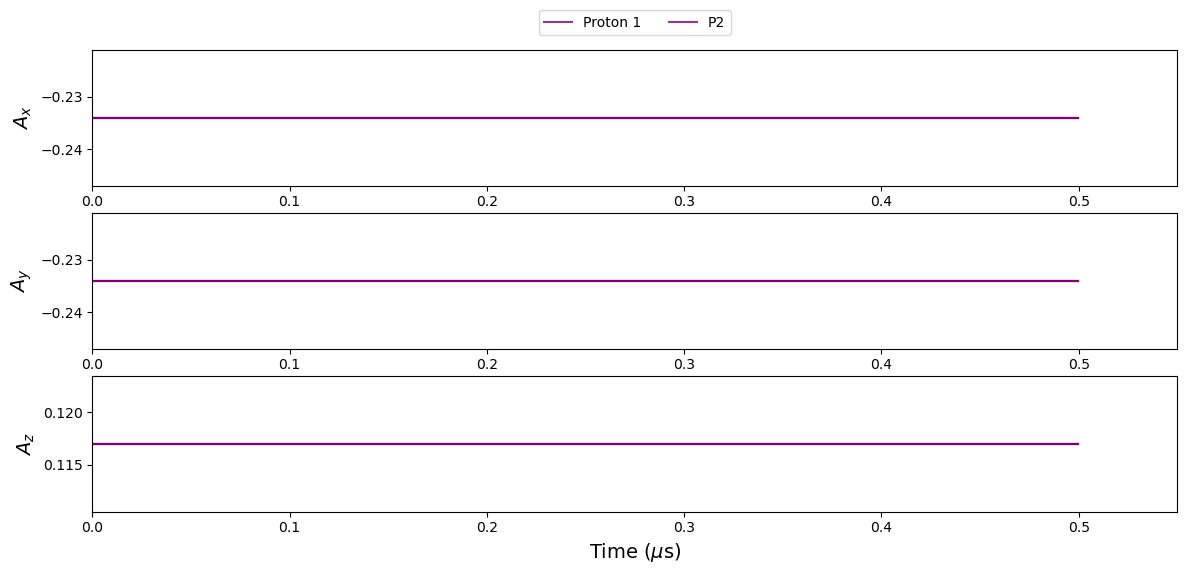

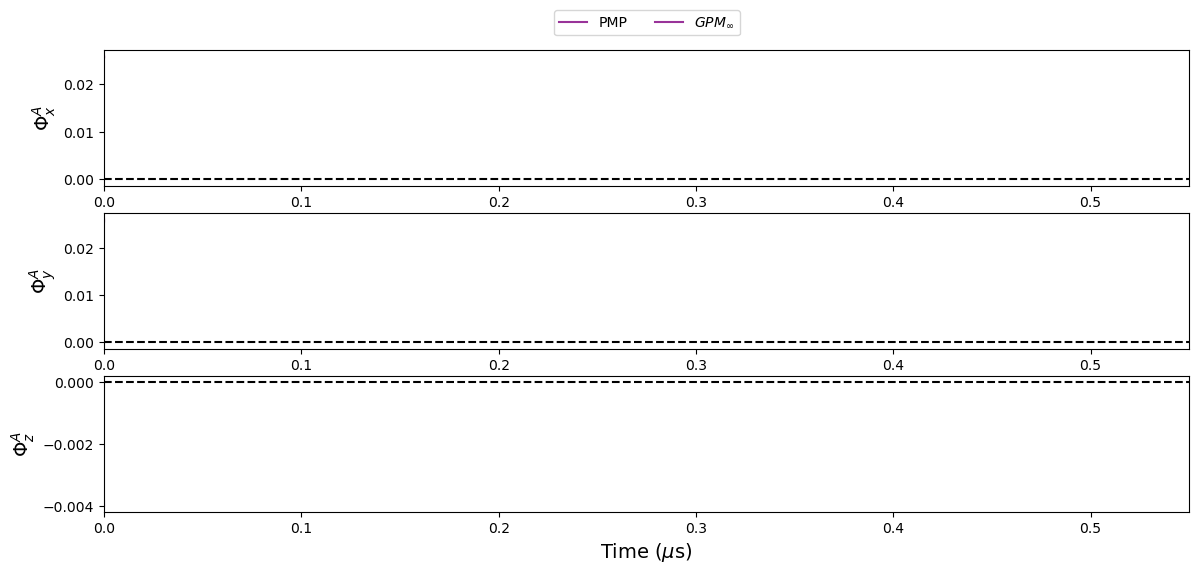

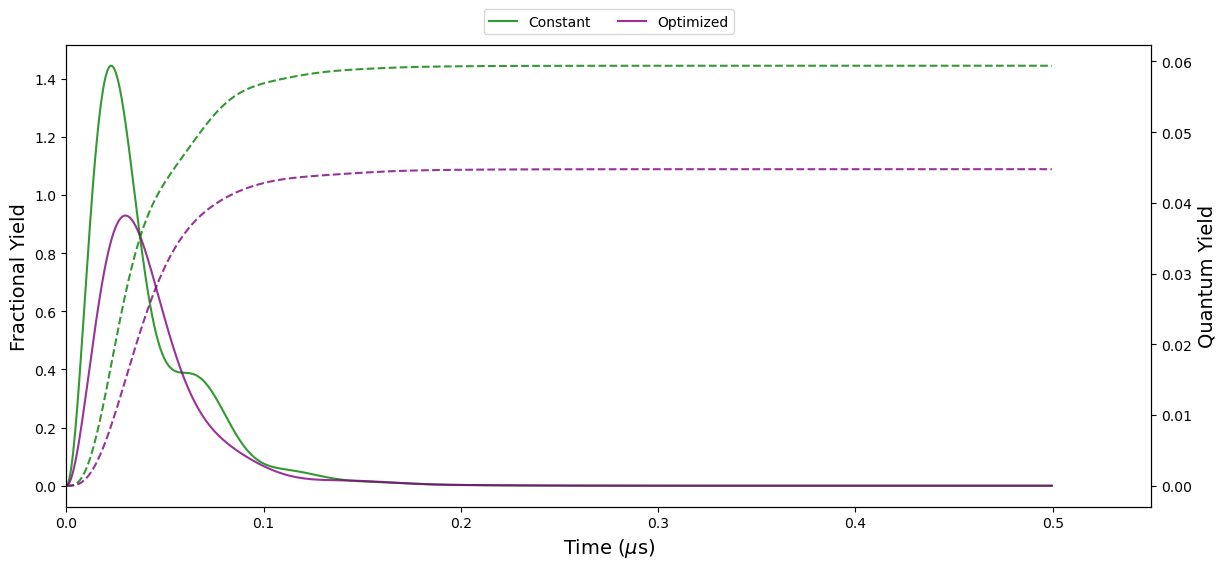

In [286]:
path = 'results/4P/Field' #FIELD 4P
#path = 'results/1P/Simultaneous' #SIMULTANEOUS 1P
#path = 'results/1P/Field' #FIELD 1P
#path = 'results/1P/Hyperfine/[-0.6,-0.3]' #HYPERFINE 1P

#only if field optimization
bounds_A = (-100,100)

#PMP filename
#filename_pmp = 'SOL_PMP_500ns.dat' #FIELD 1P
#filename_pmp = 'SOL_PMP_500ns.dat' #HYPERFINE 1P
#filename_pmp = 'SOL_PMP_G2.dat' #SIMULTANEOUS 1P
filename_pmp = 'SOL_M2_500ns.dat' #FIELD 4P

# -------------------------------- pmp results ------------------------------- #
#load controls
pmp = os.path.join(path,'M2',filename_pmp)
pmp = scipy.io.loadmat(pmp)

A_pmp = pmp['SOL_M2_s'][0][0][4][0][1][0][0][:,0].T
gA_pmp_ = -pmp['SOL_M2_s'][0][0][4][0][1][0][1][:,0].T
gA_pmp = np.ones(H.A.shape)
for j in range(H.n_nuclei):
    gA_pmp[:,j,0,0] = gA_pmp_[j,0]
    gA_pmp[:,j,1,1] = gA_pmp_[j,1]
    gA_pmp[:,j,2,2] = gA_pmp_[j,2]

u_pmp = pmp['SOL_M2_s'][0][0][4][0][0][0][0][:,0].T
gu_pmp = pmp['SOL_M2_s'][0][0][4][0][0][0][1][:,0].T
#calculate parameters
for j in range(H.n_nuclei):
    for i in range(3):
        H.A[:,j,i,i] = A_pmp[:,i]
H.omega_t = u_pmp.copy()
J_pmp,fy_pmp,iy_pmp,_,_=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)

# --------------------- plot Field + Pontryagin function --------------------- #
#Fontstyle to Helvetica
#plt.rc('font', family='Helvetica')

fig_u = plt.figure(figsize=(14,6))
fig_gu = plt.figure(figsize=(14,6))

for i in range(3):
    ax_u = fig_u.add_subplot(3,1,i+1)
    ax_gu = fig_gu.add_subplot(3,1,i+1)

    ax_u.plot(H.t[:-10]/H.gamma_e,u_pmp[:-10,i]*1.e3,color='purple',alpha=0.6)
    #ax_u.plot(H.t[:-10]/H.gamma_e,u_pmp[:-10,i]*1.e3,color='red',alpha=0.6)
    #ax_u.plot(H.t[:-10]/H.gamma_e,u_pmp[:-10,i]*1.e3,color='green',alpha=0.6)
    #ax_u.plot(H.t[:-10]/H.gamma_e,u_pmp[:-10,i]*1.e3,color='blue',alpha=0.6)

    ax_gu.plot(H.t[:-1]/H.gamma_e,gu_pmp[:-1,i]*1.e3,color='purple',alpha=0.6)
    #ax_gu.plot(H.t[:-1]/H.gamma_e,gu_bb[:-1,i]*1.e3,color='red',alpha=0.6)
    #ax_gu.plot(H.t[:-1]/H.gamma_e,gu_gpm[:-1,i]*1.e3,color='black',alpha=0.6)
    ax_gu.axhline(0.,color='black',linestyle='--')

    ax_u.set_xlim((0,.55))
    ax_gu.set_xlim((0,.55))

    ax_u.set_ylabel(r'$u_{%s}$ ($\mu$T)'%(['x','y','z'][i]),fontsize=14)
    ax_u.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    ax_gu.set_ylabel(r'$\Phi^{u}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gu.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax_u.legend(['Method 2','Method 2','Method 3','Method 4'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=4)
ax_gu.legend(['PMP','$GPM_{\infty}$'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)

# ------------------- plot Hyperfine + Pontryagin function ------------------- #
fig_A = plt.figure(figsize=(14,6))
fig_gA = plt.figure(figsize=(14,6))

for i in range(3):
    ax_A = fig_A.add_subplot(3,1,i+1)
    ax_gA = fig_gA.add_subplot(3,1,i+1)
    for j in range(H.n_nuclei):
        ax_A.plot(H.t[:-1]/H.gamma_e,A_pmp[:-1,i],color='purple',alpha=0.8)
        #ax_A.plot(H.t[:-3]/H.gamma_e,A_pmp[:-3,i],color=['red','blue'][j],alpha=0.8)
        #ax_A.plot(H.t[:-3]/H.gamma_e,A_bb[:-3,j,i,i],color='red',alpha=0.8)
        #ax_A.plot(H.t[:-3]/H.gamma_e,A_gpm[:-3,j,i,i],color='black',alpha=0.6)

        ax_gA.plot(-H.t[:-1]/H.gamma_e,gA_pmp[:-1,j,i,i],color='purple',alpha=0.8)
        #ax_gA.plot(H.t[:-1]/H.gamma_e,gA_bb[:-1,j,i,i],color='red',alpha=0.8)
        #ax_gA.plot(H.t[:-1]/H.gamma_e,gA_gpm[:-1,j,i,i],color='black',alpha=0.6)
    ax_gA.axhline(0.,color='black',linestyle='--')

    ax_A.set_xlim((0,.55))
    ax_gA.set_xlim((0,.55))

    ax_A.set_ylabel(r'$A_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_A.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    ax_gA.set_ylabel(r'$\Phi^{A}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gA.set_xlabel(r'Time ($\mu$s)',fontsize=14)

#ax_A.legend(['PMP','$GPM_{\infty}$','GPM tol = 1.e-5'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)
ax_A.legend(['Proton 1','P2'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)
ax_gA.legend(['PMP','$GPM_{\infty}$'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)

# ------------------- plot fractional and integrated yields ------------------ #
fig_y = plt.figure(figsize=(14,6))
ax = fig_y.add_subplot(1,1,1)
ax.plot(H.t[:-1]/H.gamma_e,initial_f_y[:-1],color='green',alpha=0.8)
ax.plot(H.t[:-1]/H.gamma_e,fy_pmp[:-1],color='purple',alpha=0.8)
#ax.plot(H.t[:-1]/H.gamma_e,fy_bb[:-1],color='red',alpha=0.8)
#ax.plot(H.t[:-1]/H.gamma_e,fy_gpm[:-1],color='black',alpha=0.8)
ax2 = ax.twinx()
ax2.plot(H.t[:-1]/H.gamma_e,initial_i_y[:-1],color='green',alpha=0.8,linestyle='--')
ax2.plot(H.t[:-1]/H.gamma_e,iy_pmp[:-1],color='purple',alpha=0.8,linestyle='--')
#ax2.plot(H.t[:-1]/H.gamma_e,iy_bb[:-1],color='red',alpha=0.8,linestyle='--')
#ax2.plot(H.t[:-1]/H.gamma_e,iy_gpm[:-1],color='black',alpha=0.8,linestyle='--')

ax.set_xlim((0,.55))
ax2.set_xlim((0,.55))

ax.set_ylabel('Fractional Yield',fontsize=14)
ax2.set_ylabel('Quantum Yield',fontsize=14)
ax.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax.legend(['Constant','Optimized',' $GPM_{\infty}$','GPM tol = 1.e-5'],bbox_to_anchor=[0.5, 1.05],loc='center',ncols=4)

# ------------------------------- save figures ------------------------------- #
if save:=True:
    fig_u.savefig('results/4P/Field/4P_u_u_M4.pdf',bbox_inches='tight')
    #fig_u.savefig('Presentation/png/2P_u_u.png',bbox_inches='tight',dpi=500)
    #fig_gu.savefig('Presentation/pdf/2P_u_gu.pdf',bbox_inches='tight')
    #fig_gu.savefig('Presentation/png/2P_u_gu.png',bbox_inches='tight',dpi=500)
    #fig_A.savefig('results/1P/Simultaneous/4P_S_A_M4.pdf',bbox_inches='tight')
    #fig_A.savefig('Presentation/png/2P_S_A_pmp.png',bbox_inches='tight',dpi=500)
    #fig_gA.savefig('Presentation/pdf/1P_u_gA_100ns.pdf',bbox_inches='tight')
    #fig_gA.savefig('Presentation/png/1P_u_gA_100ns.png',bbox_inches='tight',dpi=500)
    fig_y.savefig('results/1P/Field/4P_u_qy.pdf',bbox_inches='tight')
    #fig_y.savefig('Presentation/png/1P_u_qy.png',bbox_inches='tight',dpi=500)

In [284]:
pmp.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SOL_M2_s'])

In [ ]:
#calculate fft of A_bb
from scipy.fft import fft, fftfreq

# Number of sample points
N = len(H.t)-250
# sample spacing
T = H.t[1]-H.t[0]
x = np.linspace(250*T, N*T, N, endpoint=False)
yf = fft(A_bb[250:,0,0,0])
xf = fftfreq(N, T)[:N//2]
plt.figure(figsize=(14,6))
plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]),color='red')

q = xf[np.argmax(2.0/N * np.abs(yf[1:N//2]))+1]

plt.axvline(q,color='black',linestyle='--')
#plt.axvline(2*q,color='black',linestyle='--')
plt.xlim((0,0.5))

plt.xlabel(r'$\omega$ ($\mu$s$^{-1}$)',fontsize=14)

In [ ]:
path = 'results/2P/Simultaneous/[-6,-3],[-0.6,-0.3]'
A_bb = np.load(os.path.join(path,'DATA/results_GPM_infty/inf_A_2p_simultaneous_optimization.npy'))
u_bb = np.load(os.path.join(path,'DATA/results_GPM_infty/inf_u_2p_simultaneous_optimization.npy'))


#calculate parameters
H.A = A_bb.copy()
H.omega_t = u_bb.copy()
J_bb,fy_bb,iy_bb,gu_bb,gA_bb=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)

"""
H.A = A_bb.copy()
H.omega_t = u_bb.copy()

H.A[100:175,0,0,0]= bounds_A[0]
H.A[120:175,1,0,0]= bounds_A[0]

H.A[60:80,0,1,1]= bounds_A[1]
H.A[120:165,0,1,1]= bounds_A[0]
H.A[120:165,1,1,1]= bounds_A[0]

H.A[140:170,0,2,2]= bounds_A[0]
H.A[135:142,1,2,2]= bounds_A[0]
H.A[132:140,1,2,2]= bounds_A[0]

H.A[H.A>-0.45]=-0.3
H.A[H.A<-0.45]=-0.6

J_bb,fy_bb,iy_bb,gu_bb,gA_bb=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)
"""
# --------------------- plot Field + Pontryagin function --------------------- #
#Fontstyle to Helvetica
#plt.rc('font', family='Helvetica')

fig_u = plt.figure(figsize=(14,6))
fig_gu = plt.figure(figsize=(14,6))

for i in range(3):
    ax_u = fig_u.add_subplot(3,1,i+1)
    ax_gu = fig_gu.add_subplot(3,1,i+1)

    #ax_u.plot(H.t[:-1]/H.gamma_e,u_pmp[:-1,i]*1.e3,color='purple',alpha=0.6)
    ax_u.plot(H.t[:-1]/H.gamma_e,u_bb[:-1,i]*1.e3,color='red',alpha=0.6)
    #ax_u.plot(H.t[:-1]/H.gamma_e,u_gpm[:-1,i]*1.e3,color='black',alpha=0.6)

    #ax_gu.plot(H.t[:-1]/H.gamma_e,gu_pmp[:-1,i]*1.e3,color='purple',alpha=0.6)
    ax_gu.plot(H.t[:-1]/H.gamma_e,gu_bb[:-1,i]*1.e3,color='red',alpha=0.6)
    #ax_gu.plot(H.t[:-1]/H.gamma_e,gu_gpm[:-1,i]*1.e3,color='black',alpha=0.6)
    ax_gu.axhline(0.,color='black',linestyle='--')

    ax_u.set_xlim((0,1.05))
    ax_gu.set_xlim((0,1.05))

    ax_u.set_ylabel(r'$u_{%s}$ ($\mu$T)'%(['x','y','z'][i]),fontsize=14)
    ax_u.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    ax_gu.set_ylabel(r'$\Phi^{u}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gu.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax_u.legend(['$GPM_{\infty}$'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)
ax_gu.legend(['$GPM_{\infty}$'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)

# ------------------- plot Hyperfine + Pontryagin function ------------------- #
fig_A = plt.figure(figsize=(14,6))
fig_gA = plt.figure(figsize=(14,6))

for i in range(3):
    ax_A = fig_A.add_subplot(3,1,i+1)
    ax_gA = fig_gA.add_subplot(3,1,i+1)
    for j in range(H.n_nuclei):
        #ax_A.plot(H.t[:-3]/H.gamma_e,A_pmp[j,:-3,i],color='purple',alpha=0.8)
        #ax_A.plot(H.t[:-3]/H.gamma_e,A_bb[:-3,j,i,i],color=['red','blue'][j],alpha=0.8)
        ax_A.plot(H.t[:-3]/H.gamma_e,H.A[:-3,j,i,i],color=['red','blue'][j],alpha=0.8)
        #ax_A.plot(H.t[:-3]/H.gamma_e,A_gpm[:-3,j,i,i],color='black',alpha=0.6)

        #ax_gA.plot(H.t[:-1]/H.gamma_e,gA_pmp[:-1,j,i,i],color='purple',alpha=0.8)
        ax_gA.plot(H.t[:-1]/H.gamma_e,gA_bb[:-1,j,i,i],color=['red','blue'][j],alpha=0.8)
        #ax_gA.plot(H.t[:-1]/H.gamma_e,gA_gpm[:-1,j,i,i],color='black',alpha=0.6)
    ax_gA.axhline(0.,color='black',linestyle='--')

    ax_A.set_xlim((0,1.05))
    #ax_A.set_xticks(range(0,500,10))
    ax_gA.set_xlim((0,1.05))

    ax_A.set_ylabel(r'$A_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_A.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    ax_gA.set_ylabel(r'$\Phi^{A}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gA.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax_A.legend(['P1','P2'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)
ax_gA.legend(['P1','P2'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)

# ------------------- plot fractional and integrated yields ------------------ #
fig_y = plt.figure(figsize=(14,6))
ax = fig_y.add_subplot(1,1,1)
ax.plot(H.t[:-1]/H.gamma_e,initial_f_y[:-1],color='green',alpha=0.8)
#ax.plot(H.t[:-1]/H.gamma_e,fy_pmp[:-1],color='purple',alpha=0.8)
ax.plot(H.t[:-1]/H.gamma_e,fy_bb[:-1],color='red',alpha=0.8)
#ax.plot(H.t[:-1]/H.gamma_e,fy_gpm[:-1],color='black',alpha=0.8)
ax2 = ax.twinx()
ax2.plot(H.t[:-1]/H.gamma_e,initial_i_y[:-1],color='green',alpha=0.8,linestyle='--')
#ax2.plot(H.t[:-1]/H.gamma_e,iy_pmp[:-1],color='purple',alpha=0.8,linestyle='--')
ax2.plot(H.t[:-1]/H.gamma_e,iy_bb[:-1],color='red',alpha=0.8,linestyle='--')
#ax2.plot(H.t[:-1]/H.gamma_e,iy_gpm[:-1],color='black',alpha=0.8,linestyle='--')

ax.set_xlim((0,1.05))
ax2.set_xlim((0,1.05))

ax.set_ylabel('Fractional Yield',fontsize=14)
ax2.set_ylabel('Quantum Yield',fontsize=14)
ax.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax.legend(['Constant',' $GPM_{\infty}$'],bbox_to_anchor=[0.5, 1.05],loc='center',ncols=4)



#fig_u.savefig('Presentation/pdf/2P_simultaneous_u.pdf',bbox_inches='tight')
#fig_u.savefig('Presentation/png/2P_simultaneous_u.png',bbox_inches='tight',dpi=500)
#fig_gu.savefig('Presentation/pdf/2P_simultaneous_gu.pdf',bbox_inches='tight')
#fig_gu.savefig('Presentation/png/2P_simultaneous_gu.png',bbox_inches='tight',dpi=500)
fig_A.savefig('Presentation/pdf/2P_simultaneous_A_nochange.pdf',bbox_inches='tight')
fig_A.savefig('Presentation/png/2P_simultaneous_A_nochange.png',bbox_inches='tight',dpi=500)
#fig_gA.savefig('Presentation/pdf/2P_simultaneous_gA.pdf',bbox_inches='tight')
#fig_gA.savefig('Presentation/png/2P_simultaneous_gA.png',bbox_inches='tight',dpi=500)
#fig_y.savefig('Presentation/pdf/2P_simultaneous_qy.pdf',bbox_inches='tight')
#fig_y.savefig('Presentation/png/2P_simultaneous_qy.png',bbox_inches='tight',dpi=500)

Epoch: 0/1, J: 1.47034970e-01, J2: 4.96997015e-02,d_x0: 5.3671e+06, Time: 11:52
Epoch: 0/1, J: 1.73138455e-01, J2: 2.35962162e-02,d_x0: 6.1598e+06, Time: 11:52


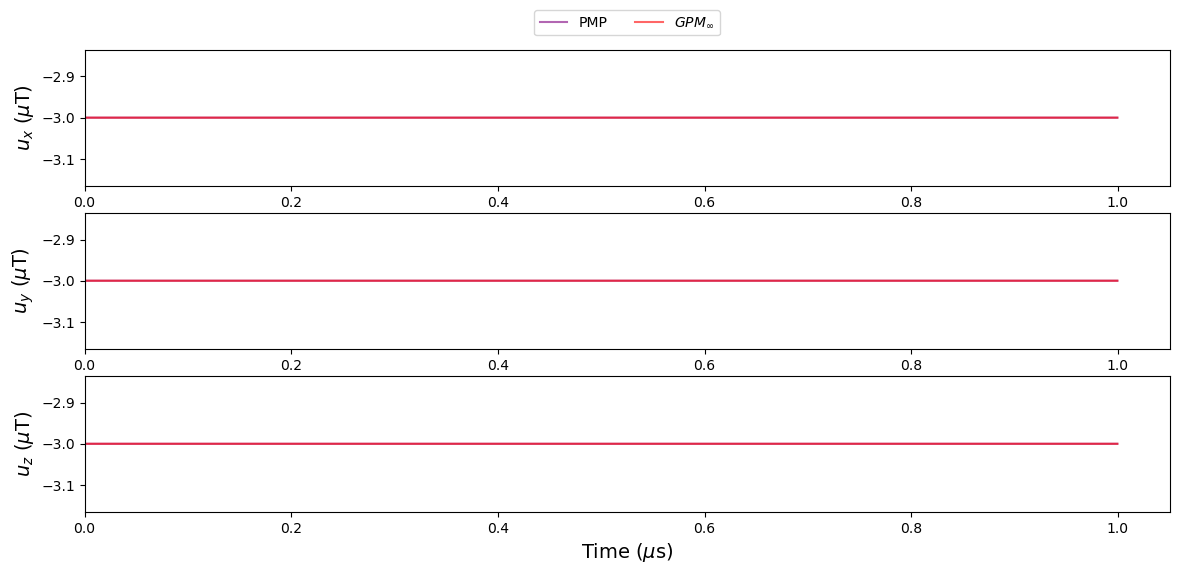

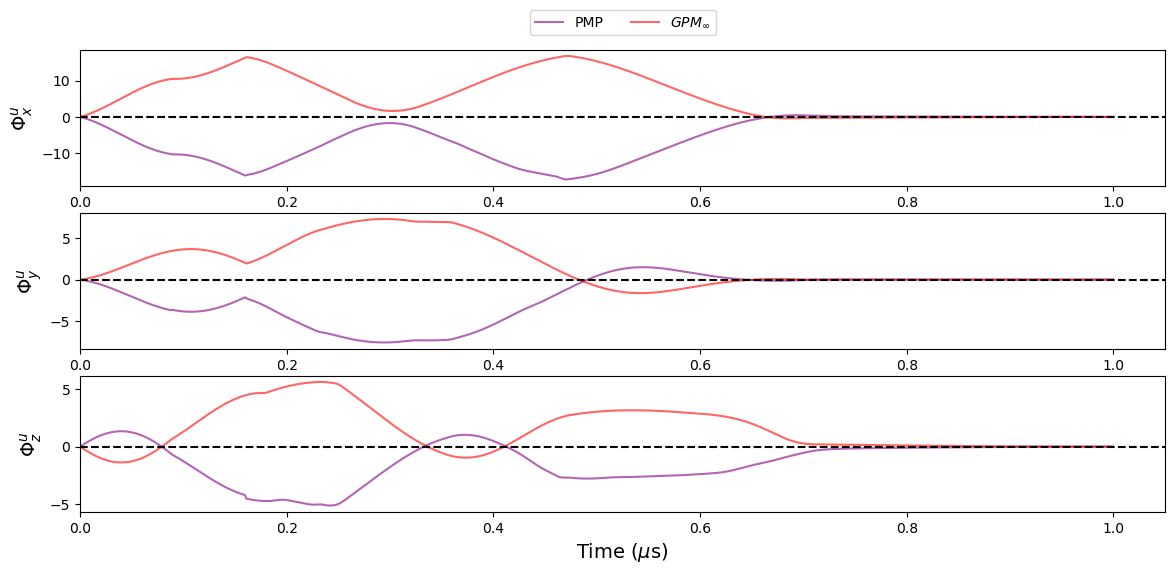

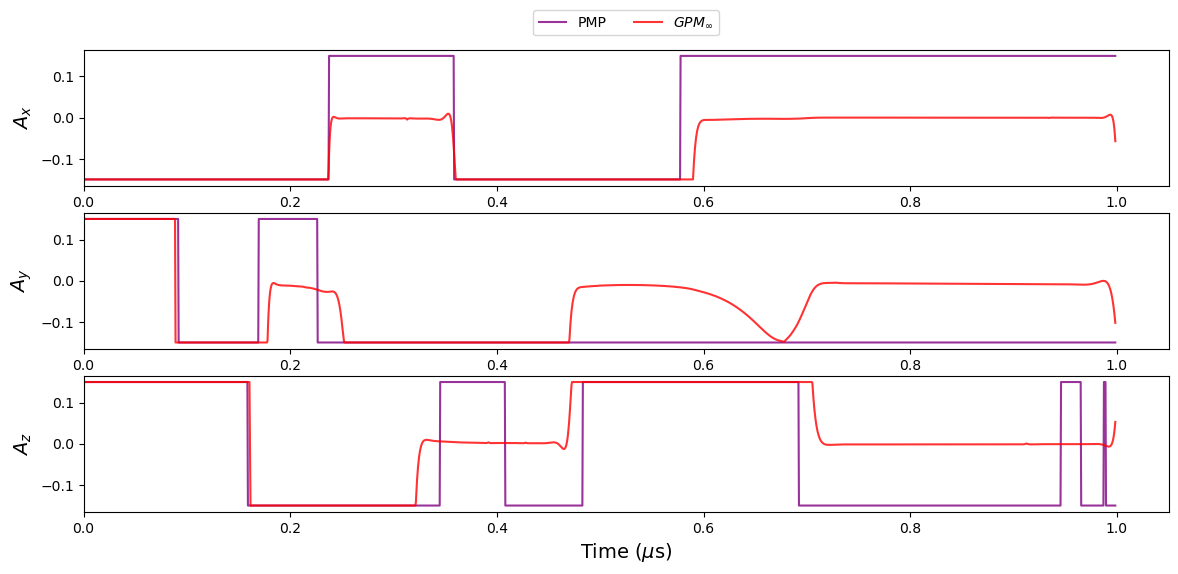

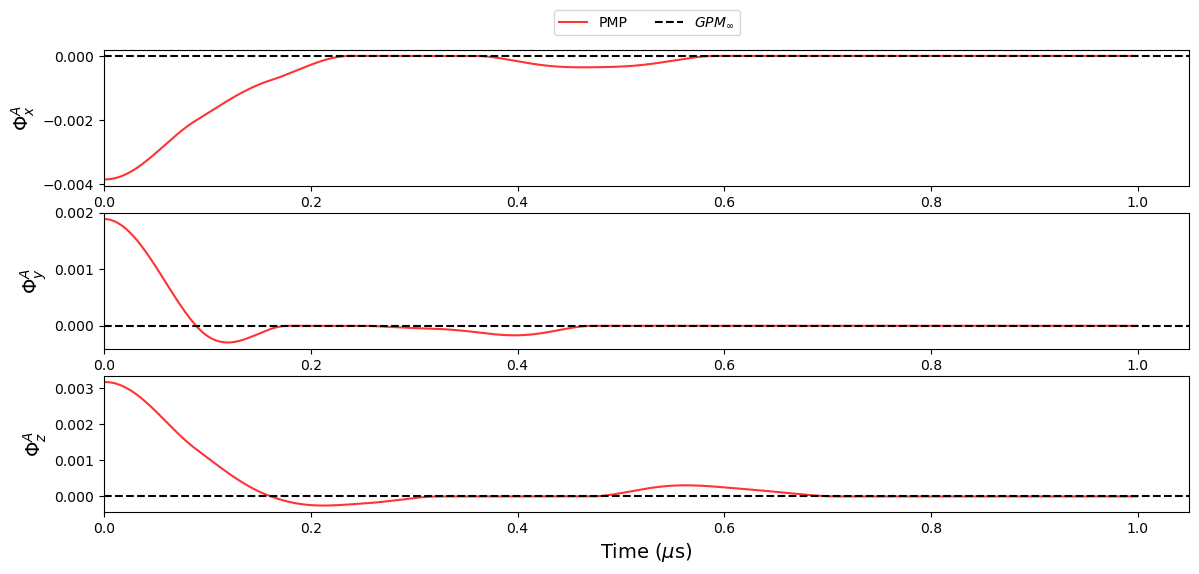

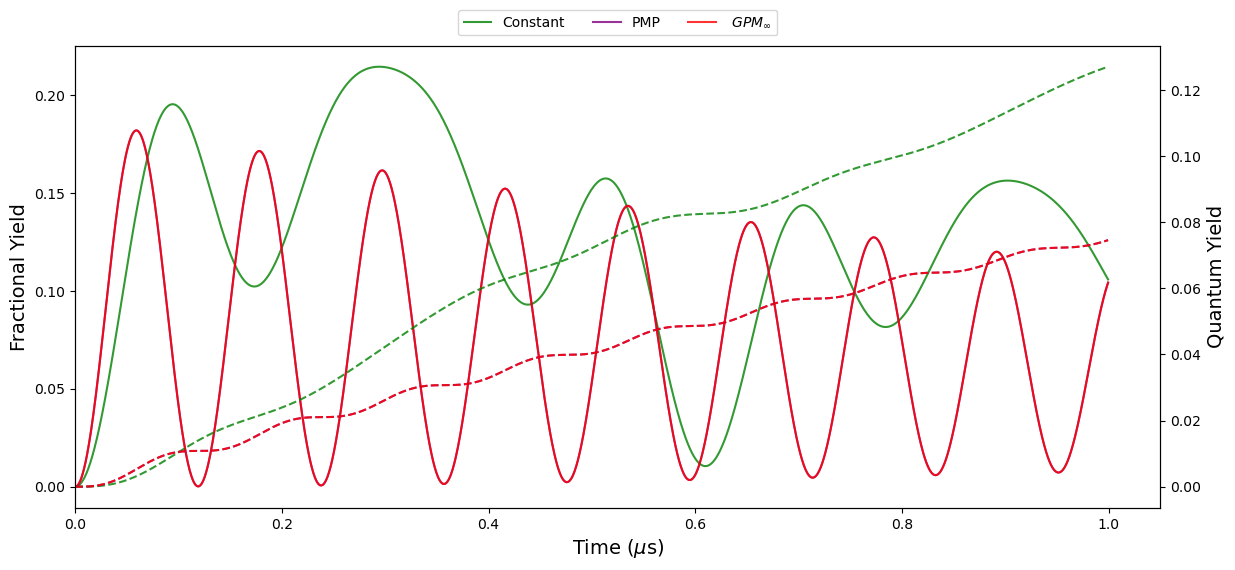

In [72]:
path = 'results/1P/Hyperfine/[-0.15,0.15]' #Hyperfine 1P

#PMP filename
filename_pmp = '1P_MAX_T_1e-05_2000.mat' #HYPERFINE 1P 1us

# -------------------------------- pmp results ------------------------------- #
#load controls
pmp = os.path.join(path,'results_PMP',filename_pmp)
pmp = scipy.io.loadmat(pmp)
A_pmp = pmp['sol_PMP'][0][0][-1][0][0][1][0][0].T#[::2]
gA_pmp_ = -pmp['sol_PMP'][0][0][-1][0][0][1][0][1].T#[::2]
gA_pmp = np.ones(H.A.shape)

gA_pmp[:,0,0,0] = gA_pmp_[:,0]
gA_pmp[:,0,1,1] = gA_pmp_[:,1]
gA_pmp[:,0,2,2] = gA_pmp_[:,2]

u_pmp = pmp['sol_PMP'][0][0][-1][0][0][0][0][0].T#[::2]
gu_pmp = -pmp['sol_PMP'][0][0][-1][0][0][0][0][1].T#[::2]
#calculate parameters
for i in range(3):
    H.A[:,0,i,i] = A_pmp[:,i]
H.omega_t = u_pmp.copy()
J_pmp,fy_pmp,iy_pmp,_,_=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)
# ----------------------------- gpm infty results ---------------------------- #
#load controls
A_bb = np.load(os.path.join(path,'results_GPM_infty/-15e-2_15e-2_A_1p_A_optimization.npy'))
u_bb = np.load(os.path.join(path,'results_GPM_infty/-15e-2_15e-2_u_1p_A_optimization.npy'))
#calculate parameters
H.A = A_bb.copy()
H.omega_t = u_bb.copy()
J_bb,fy_bb,iy_bb,gu_bb,gA_bb=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)
# --------------------- plot Field + Pontryagin function --------------------- #
#Fontstyle to Helvetica
#plt.rc('font', family='Helvetica')

fig_u = plt.figure(figsize=(14,6))
fig_gu = plt.figure(figsize=(14,6))

for i in range(3):
    ax_u = fig_u.add_subplot(3,1,i+1)
    ax_gu = fig_gu.add_subplot(3,1,i+1)

    ax_u.plot(H.t[:-1]/H.gamma_e,u_pmp[:-1,i]*1.e3,color='purple',alpha=0.6)
    ax_u.plot(H.t[:-1]/H.gamma_e,u_bb[:-1,i]*1.e3,color='red',alpha=0.6)
    #ax_u.plot(H.t[:-1]/H.gamma_e,u_gpm[:-1,i]*1.e3,color='black',alpha=0.6)

    ax_gu.plot(H.t[:-1]/H.gamma_e,gu_pmp[:-1,i]*1.e3,color='purple',alpha=0.6)
    ax_gu.plot(H.t[:-1]/H.gamma_e,gu_bb[:-1,i]*1.e3,color='red',alpha=0.6)
    #ax_gu.plot(H.t[:-1]/H.gamma_e,gu_gpm[:-1,i]*1.e3,color='black',alpha=0.6)
    ax_gu.axhline(0.,color='black',linestyle='--')

    ax_u.set_xlim((0,1.05))
    ax_gu.set_xlim((0,1.05))

    ax_u.set_ylabel(r'$u_{%s}$ ($\mu$T)'%(['x','y','z'][i]),fontsize=14)
    ax_u.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    ax_gu.set_ylabel(r'$\Phi^{u}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gu.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax_u.legend(['PMP','$GPM_{\infty}$','GPM tol = 1.e-5'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)
ax_gu.legend(['PMP','$GPM_{\infty}$'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)

# ------------------- plot Hyperfine + Pontryagin function ------------------- #
fig_A = plt.figure(figsize=(14,6))
fig_gA = plt.figure(figsize=(14,6))

for i in range(3):
    ax_A = fig_A.add_subplot(3,1,i+1)
    ax_gA = fig_gA.add_subplot(3,1,i+1)
    for j in range(H.n_nuclei):
        ax_A.plot(H.t[:-3]/H.gamma_e,A_pmp[:-3,i],color='purple',alpha=0.8)
        ax_A.plot(H.t[:-3]/H.gamma_e,A_bb[:-3,j,i,i],color='red',alpha=0.8)
        #ax_A.plot(H.t[:-3]/H.gamma_e,A_gpm[:-3,j,i,i],color='black',alpha=0.6)

        #ax_gA.plot(H.t[:-1]/H.gamma_e,gA_pmp[:-1,j,i,i],color='purple',alpha=0.8)
        ax_gA.plot(H.t[:-1]/H.gamma_e,gA_bb[:-1,j,i,i],color='red',alpha=0.8)
        #ax_gA.plot(H.t[:-1]/H.gamma_e,gA_gpm[:-1,j,i,i],color='black',alpha=0.6)
    ax_gA.axhline(0.,color='black',linestyle='--')

    ax_A.set_xlim((0,1.05))
    ax_gA.set_xlim((0,1.05))

    ax_A.set_ylabel(r'$A_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_A.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    ax_gA.set_ylabel(r'$\Phi^{A}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gA.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax_A.legend(['PMP','$GPM_{\infty}$','GPM tol = 1.e-5'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)
ax_gA.legend(['PMP','$GPM_{\infty}$'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=3)

# ------------------- plot fractional and integrated yields ------------------ #
fig_y = plt.figure(figsize=(14,6))
ax = fig_y.add_subplot(1,1,1)
ax.plot(H.t[:-1]/H.gamma_e,initial_f_y[:-1],color='green',alpha=0.8)
ax.plot(H.t[:-1]/H.gamma_e,fy_pmp[:-1],color='purple',alpha=0.8)
ax.plot(H.t[:-1]/H.gamma_e,fy_bb[:-1],color='red',alpha=0.8)
#ax.plot(H.t[:-1]/H.gamma_e,fy_gpm[:-1],color='black',alpha=0.8)
ax2 = ax.twinx()
ax2.plot(H.t[:-1]/H.gamma_e,initial_i_y[:-1],color='green',alpha=0.8,linestyle='--')
ax2.plot(H.t[:-1]/H.gamma_e,iy_pmp[:-1],color='purple',alpha=0.8,linestyle='--')
ax2.plot(H.t[:-1]/H.gamma_e,iy_bb[:-1],color='red',alpha=0.8,linestyle='--')
#ax2.plot(H.t[:-1]/H.gamma_e,iy_gpm[:-1],color='black',alpha=0.8,linestyle='--')

ax.set_xlim((0,1.05))
ax2.set_xlim((0,1.05))

ax.set_ylabel('Fractional Yield',fontsize=14)
ax2.set_ylabel('Quantum Yield',fontsize=14)
ax.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax.legend(['Constant','PMP',' $GPM_{\infty}$','GPM tol = 1.e-5'],bbox_to_anchor=[0.5, 1.05],loc='center',ncols=4)

# ------------------------------- save figures ------------------------------- #
fig_u.savefig('Presentation/pdf/1P_A_u_0range.pdf',bbox_inches='tight')
fig_u.savefig('Presentation/png/1P_A_u_0range.png',bbox_inches='tight',dpi=500)
fig_gu.savefig('Presentation/pdf/1P_A_gu_0range.pdf',bbox_inches='tight')
fig_gu.savefig('Presentation/png/1P_A_gu_0range.png',bbox_inches='tight',dpi=500)
fig_A.savefig('Presentation/pdf/1P_A_A_0range.pdf',bbox_inches='tight')
fig_A.savefig('Presentation/png/1P_A_A_0range.png',bbox_inches='tight',dpi=500)
fig_gA.savefig('Presentation/pdf/1P_A_gA_0range.pdf',bbox_inches='tight')
fig_gA.savefig('Presentation/png/1P_A_gA_0range.png',bbox_inches='tight',dpi=500)
fig_y.savefig('Presentation/pdf/1P_A_qy_0range.pdf',bbox_inches='tight')
fig_y.savefig('Presentation/png/1P_A_qy_0range.png',bbox_inches='tight',dpi=500)

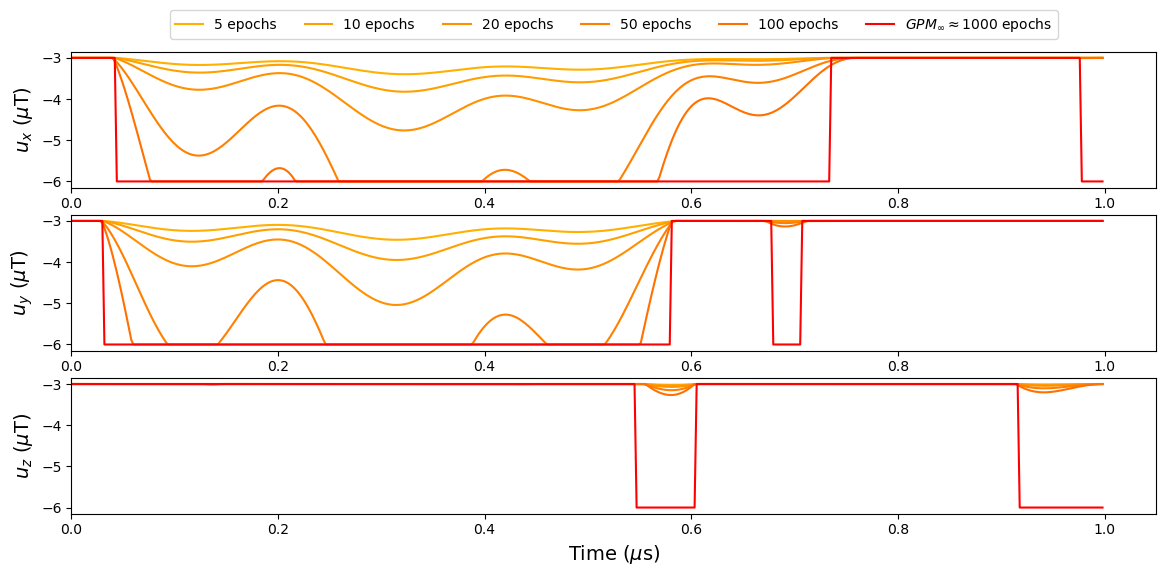

In [9]:
# --------------------- plot Field + Pontryagin function --------------------- #
fig_u = plt.figure(figsize=(14,6))
#set fontstyle for matplotlib

cmp = plt.cm.autumn(np.linspace(0,1,17)[::-1])

for i in range(3):
    ax_u = fig_u.add_subplot(3,1,i+1)
    
    ax_u.plot(H.t[:-1]/H.gamma_e,u_gpm0[:-1,i]*1.e3,color=cmp[5])
    ax_u.plot(H.t[:-1]/H.gamma_e,u_gpm1[:-1,i]*1.e3,color=cmp[6])
    ax_u.plot(H.t[:-1]/H.gamma_e,u_gpm2[:-1,i]*1.e3,color=cmp[7])
    ax_u.plot(H.t[:-1]/H.gamma_e,u_gpm3[:-1,i]*1.e3,color=cmp[8])
    ax_u.plot(H.t[:-1]/H.gamma_e,u_gpm4[:-1,i]*1.e3,color=cmp[9])
    
    ax_u.plot(H.t[:-1]/H.gamma_e,u_bb[:-1,i]*1.e3,color='red')
    
    ax_u.set_xlim((0,1.05))

    ax_u.set_ylabel(r'$u_{%s}$ ($\mu$T)'%(['x','y','z'][i]),fontsize=14)
    ax_u.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    
ax_u.legend(['5 epochs','10 epochs','20 epochs','50 epochs','100 epochs',r'$GPM_{\infty}\approx$1000 epochs'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=6)

fig_u.savefig('Presentation/pdf/1P_u_epoch_evolution.pdf',bbox_inches='tight')
fig_u.savefig('Presentation/png/1P_u_epoch_evolution.png',bbox_inches='tight',dpi=500)

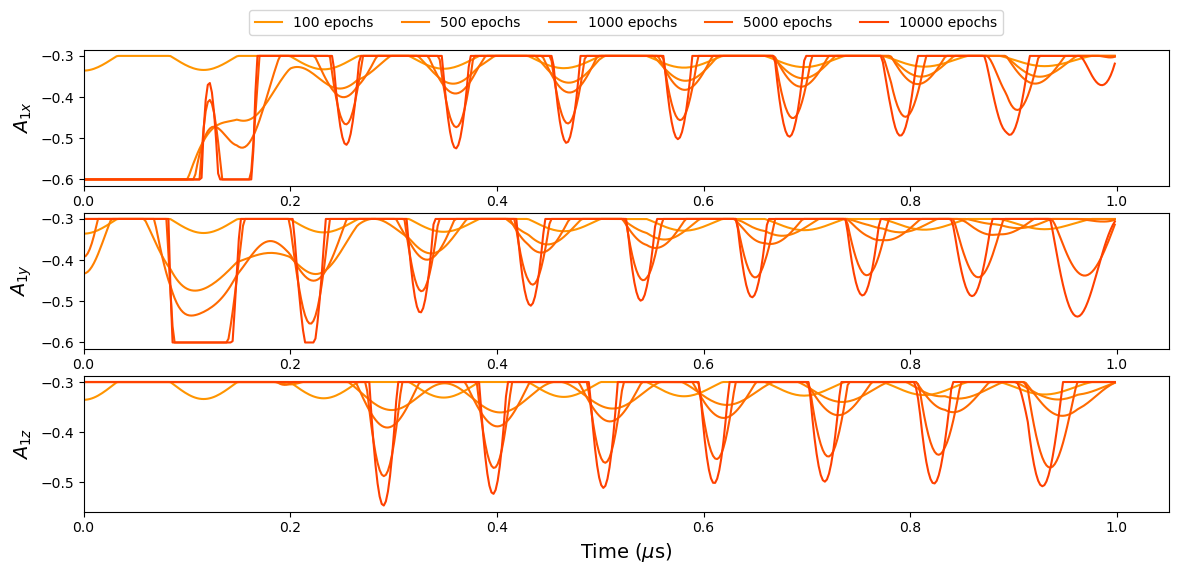

In [95]:
# --------------------- plot A + Pontryagin function --------------------- #
fig_A = plt.figure(figsize=(14,6))
#set fontstyle for matplotlib

cmp = plt.cm.autumn(np.linspace(0,1,13)[::-1])

for i in range(3):
    ax_A = fig_A.add_subplot(3,1,i+1)
    
    ax_A.plot(H.t[:-1]/H.gamma_e,A_gpm0[:-1,0,i,i],color=cmp[5])
    ax_A.plot(H.t[:-1]/H.gamma_e,A_gpm1[:-1,0,i,i],color=cmp[6])
    ax_A.plot(H.t[:-1]/H.gamma_e,A_gpm2[:-1,0,i,i],color=cmp[7])
    ax_A.plot(H.t[:-1]/H.gamma_e,A_gpm3[:-1,0,i,i],color=cmp[8])
    ax_A.plot(H.t[:-1]/H.gamma_e,A_gpm4[:-1,0,i,i],color=cmp[9])
    
    ax_A.set_xlim((0,1.05))

    ax_A.set_ylabel(r'$A_{1%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_A.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    
ax_A.legend(['100 epochs','500 epochs','1000 epochs','5000 epochs','10000 epochs'],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=6)

fig_A.savefig('Presentation/pdf/1P_A_epoch_evolution.pdf',bbox_inches='tight')
fig_A.savefig('Presentation/png/1P_A_epoch_evolution.png',bbox_inches='tight',dpi=500)

Epoch: 0/1, J: 1.48584350e-01, J2: 4.81503212e-02,d_x0: 5.2727e+06, Time: 19:0


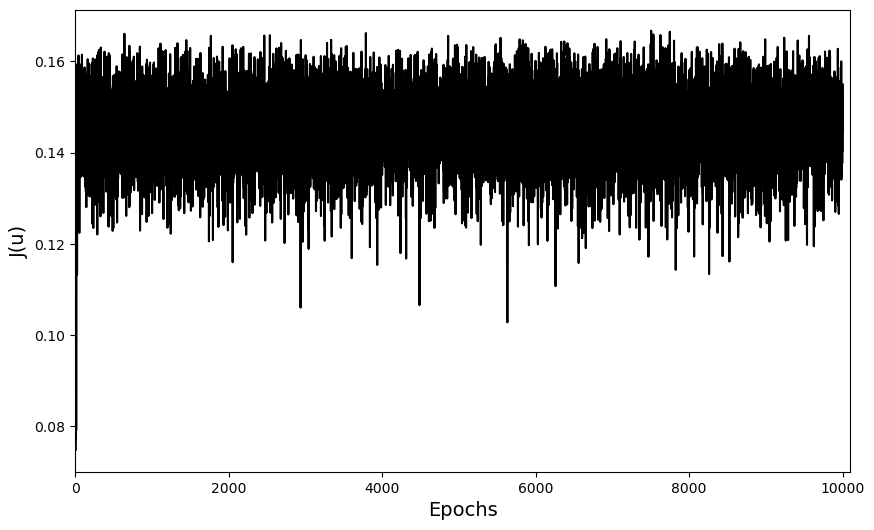

In [89]:
A_bb = A_gpm4#np.load(os.path.join(path,'DATA/results_GPM_infty/inf_A_1p_u_optimization.npy'))
u_bb = u_gpm4#np.load(os.path.join(path,'DATA/results_GPM_infty/inf_u_1p_u_optimization.npy'))
#calculate parameters
H.A = A_bb.copy()
H.omega_t = u_bb.copy()
J_bb,fy_bb,iy_bb,gu_bb,gA_bb=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,(-100,100)),maximize=True)

# --------------------- plot Field + Pontryagin function --------------------- #
fig_u = plt.figure(figsize=(10,6))

cmp = plt.cm.autumn(np.linspace(0,1,13)[::-1])

ax_u = fig_u.add_subplot(111)
x = np.cumsum(epochs)-1

ax_u.plot(-100,J_gpm[x[0]],'p',color=cmp[5])
ax_u.plot(-100,J_gpm[x[1]],'p',color=cmp[6])
ax_u.plot(-100,J_gpm[x[2]],'p',color=cmp[7])
ax_u.plot(-100,J_gpm[x[3]],'p',color=cmp[8])
ax_u.plot(-100,J_gpm[x[4]],'p',color=cmp[9])
#ax_u.plot(-100,J_bb[-1],'p',color='red')
#ax_u.legend(['5 epochs','10 epochs','20 epochs','50 epochs','100 epochs',r'$GPM_{\infty}\approx$1000 epochs'],bbox_to_anchor=[0.5, 1.05],loc='center',ncols=6)

ax_u.plot(J_gpm,color='black')
#ax_u.plot(x[0],J_gpm[x[0]],'p',color=cmp[5])
#ax_u.plot(x[1],J_gpm[x[1]],'p',color=cmp[6])
#ax_u.plot(x[2],J_gpm[x[2]],'p',color=cmp[7])
#ax_u.plot(x[3],J_gpm[x[3]],'p',color=cmp[8])
#ax_u.plot(x[4],J_gpm[x[4]],'p',color=cmp[9])
#ax_u.plot(len(J_gpm),J_bb[-1],'p',color='red')
ax_u.set_ylabel('J(u)',fontsize=14)
ax_u.set_xlabel('Epochs',fontsize=14)
ax_u.set_xlim((-0,10100))

#fig_u.savefig('Presentation/pdf/1P_JA_epoch_evolution.pdf',bbox_inches='tight')
fig_u.savefig('Presentation/png/1P_JA_epoch_evolution_OVER.png',bbox_inches='tight',dpi=500)

Epoch: 0/1, J: 1.30090821e-01, J2: 6.66438665e-02,d_x0: 4.7091e+06, Time: 15:27
0.13009082074109263
Epoch: 0/1, J: 1.30528989e-01, J2: 6.62056980e-02,d_x0: 4.7246e+06, Time: 15:27
0.13052898929623974
Epoch: 0/1, J: 1.30557736e-01, J2: 6.61769514e-02,d_x0: 4.7255e+06, Time: 15:27
0.13055773591077513
Epoch: 0/1, J: 1.30558269e-01, J2: 6.61764180e-02,d_x0: 4.7255e+06, Time: 15:27
0.13055826927394404
Epoch: 0/1, J: 1.30558285e-01, J2: 6.61764022e-02,d_x0: 4.7255e+06, Time: 15:27
0.1305582850383224


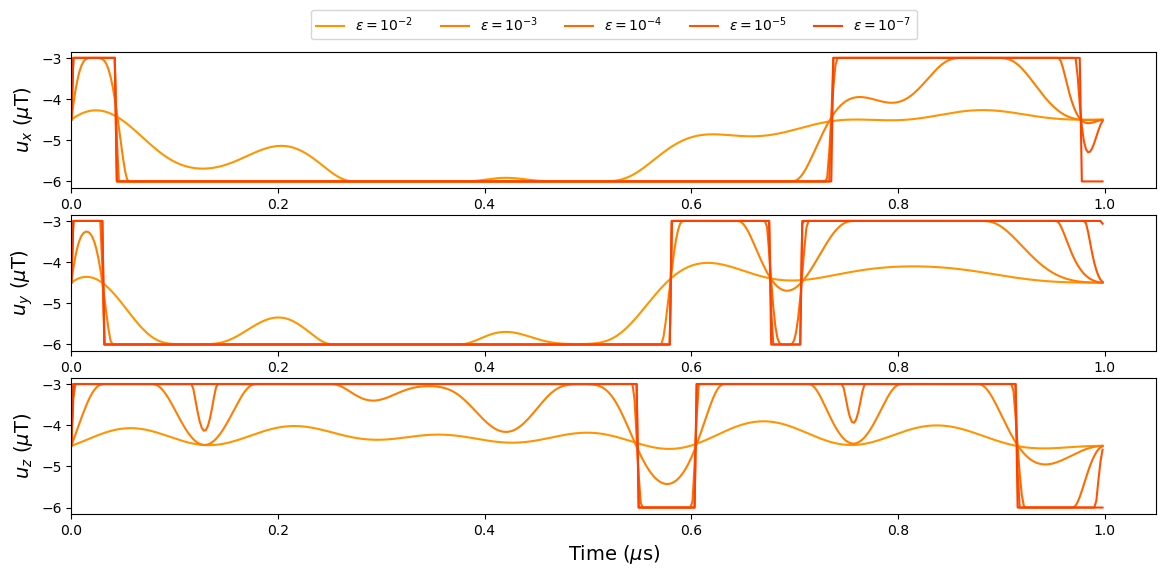

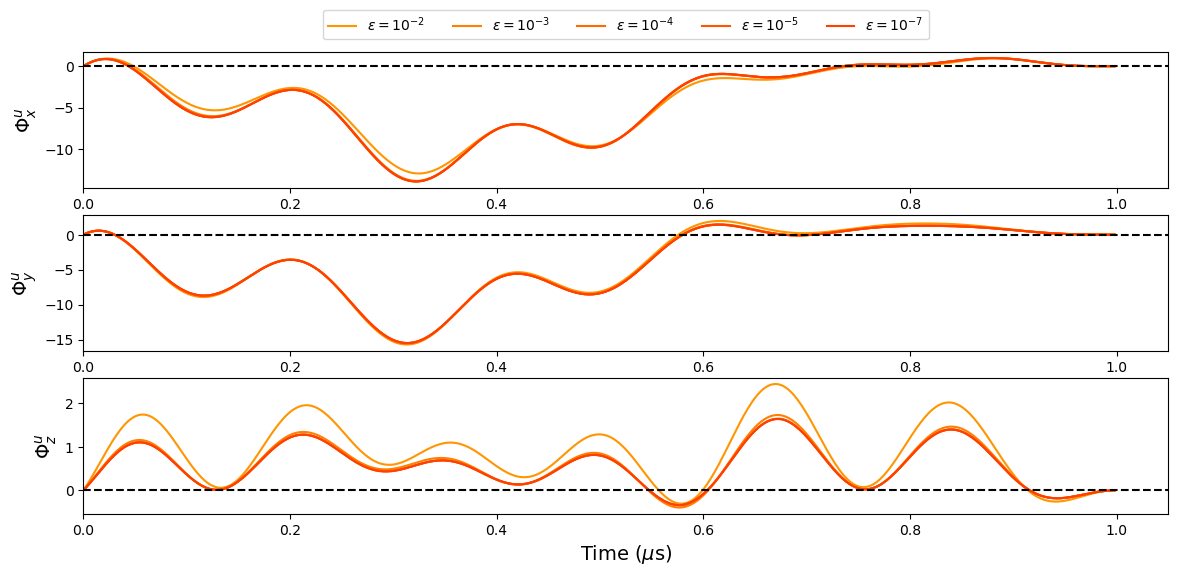

In [160]:
files = ['Presentation/jose/1P_MAX_T_1e-0%i_500_T2.mat'%i for i in [2,3,4,5,7]]
u=[]
g_u = []
for file in files:
    pmp = scipy.io.loadmat(file)
    #A_pmp = pmp['sol_PMP'][0][0][-1][0][0][1][0][0].T#[::2]
    u.append(pmp['sol_PMP'][0][0][-1][0][0][0][0][0].T)
    g_u.append(pmp['sol_PMP'][0][0][-1][0][0][0][0][1].T)
    H.omega_t = u[-1].copy()
    _=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,(-100,100)),maximize=True)
    print(_[0][-1])


# --------------------- plot Field + Pontryagin function --------------------- #
fig_u = plt.figure(figsize=(14,6))
fig_gu = plt.figure(figsize=(14,6))
#set fontstyle for matplotlib

cmp = plt.cm.autumn(np.linspace(0,1,13)[::-1])

for i in range(3):
    ax_u = fig_u.add_subplot(3,1,i+1)
    ax_gu = fig_gu.add_subplot(3,1,i+1)
    
    ax_u.plot(H.t[:-1]/H.gamma_e,u[0][:-1,i]*1.e3,color=cmp[5])
    ax_u.plot(H.t[:-1]/H.gamma_e,u[1][:-1,i]*1.e3,color=cmp[6])
    ax_u.plot(H.t[:-1]/H.gamma_e,u[2][:-1,i]*1.e3,color=cmp[7])
    ax_u.plot(H.t[:-1]/H.gamma_e,u[3][:-1,i]*1.e3,color=cmp[8])
    ax_u.plot(H.t[:-1]/H.gamma_e,u[4][:-1,i]*1.e3,color=cmp[9])
    
    
    ax_gu.plot(H.t[:-1]/H.gamma_e,g_u[0][:-1,i]*1.e3,color=cmp[5])
    ax_gu.plot(H.t[:-1]/H.gamma_e,g_u[1][:-1,i]*1.e3,color=cmp[6])
    ax_gu.plot(H.t[:-1]/H.gamma_e,g_u[2][:-1,i]*1.e3,color=cmp[7])
    ax_gu.plot(H.t[:-1]/H.gamma_e,g_u[3][:-1,i]*1.e3,color=cmp[8])
    ax_gu.plot(H.t[:-1]/H.gamma_e,g_u[4][:-1,i]*1.e3,color=cmp[9])

    ax_gu.axhline(0,color='black',linestyle='--')
    ax_u.set_xlim((0,1.05))
    ax_gu.set_xlim((0,1.05))

    ax_u.set_ylabel(r'$u_{%s}$ ($\mu$T)'%(['x','y','z'][i]),fontsize=14)
    ax_u.set_xlabel(r'Time ($\mu$s)',fontsize=14)

    ax_gu.set_ylabel(r'$\Phi^{u}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gu.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax_u.legend([r'$\epsilon=10^{-%i}$'%i for i in [2,3,4,5,7]],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=6)
ax_gu.legend([r'$\epsilon=10^{-%i}$'%i for i in [2,3,4,5,7]],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=6)

fig_u.savefig('Presentation/pdf/1P_u_PMP_epsilon.pdf',bbox_inches='tight')
fig_u.savefig('Presentation/png/1P_u_PMP_epsilon.png',bbox_inches='tight',dpi=500)
fig_gu.savefig('Presentation/pdf/1P_gu_PMP_epsilon.pdf',bbox_inches='tight')
fig_gu.savefig('Presentation/png/1P_gu_PMP_epsilon.png',bbox_inches='tight',dpi=500)


Epoch: 0/1, J: 8.32683020e-02, J2: 1.13466369e-01,d_x0: 3.2194e+06, Time: 15:28
0.08326830203106488
Epoch: 0/1, J: 7.45558879e-02, J2: 1.22178781e-01,d_x0: 3.0396e+06, Time: 15:28
0.07455588787441639
Epoch: 0/1, J: 1.12648420e-01, J2: 8.40862497e-02,d_x0: 4.1439e+06, Time: 15:28
0.11264841965308452
Epoch: 0/1, J: 7.51025249e-02, J2: 1.21632143e-01,d_x0: 3.0438e+06, Time: 15:28
0.07510252487943916


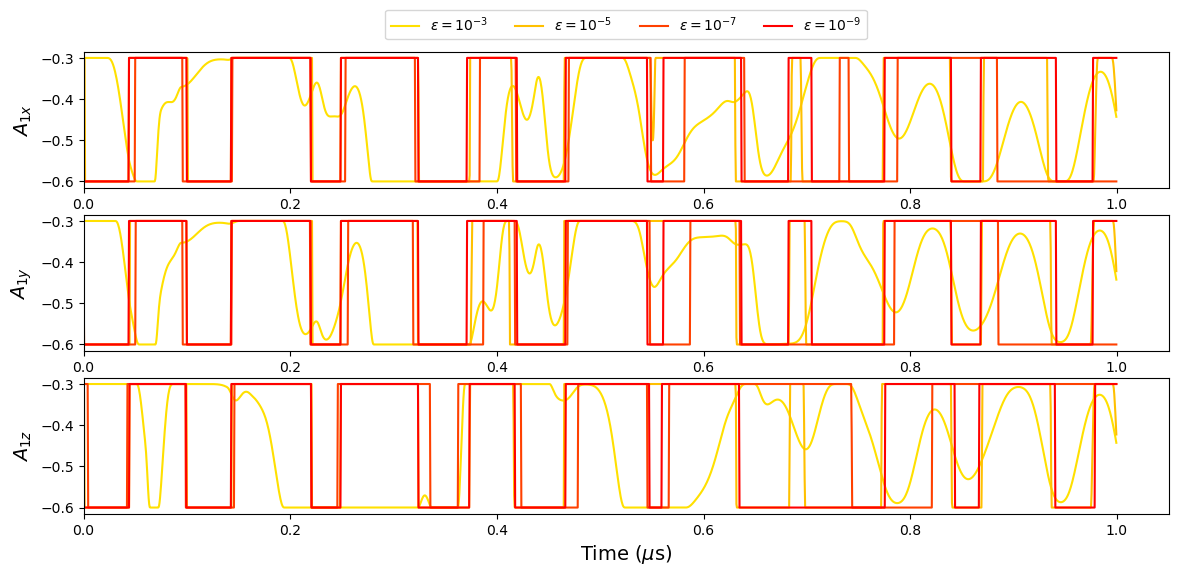

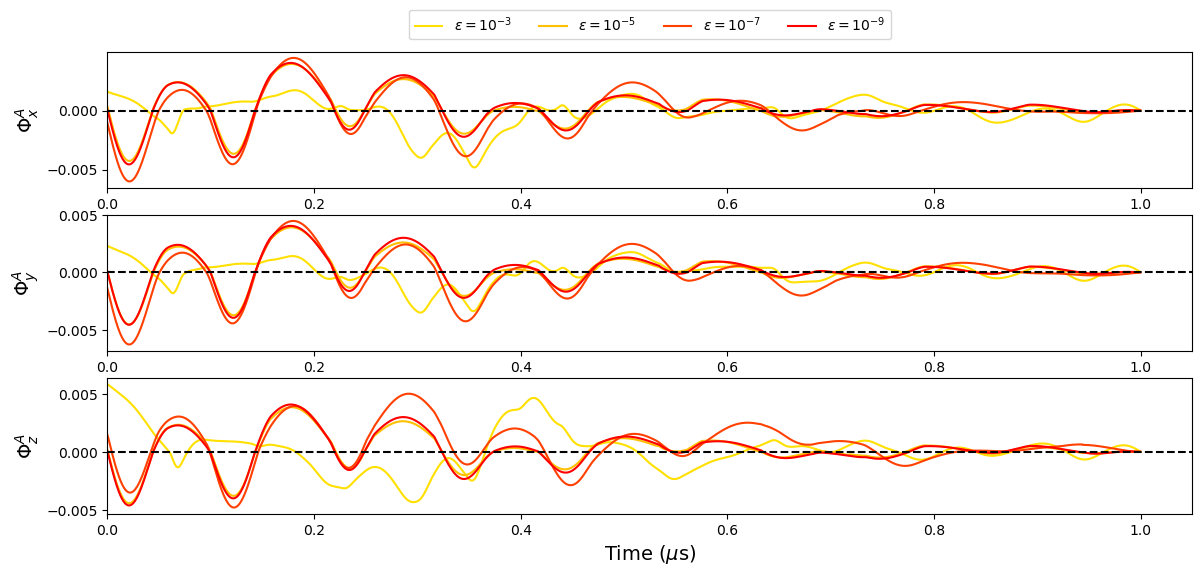

In [163]:
files = ['Presentation/jose/A/1P_MAX_T_1e-0%i_2000_T2.mat'%i for i in [3,5,7,9]]
A=[]
g_A=[]
for file in files:
    pmp = scipy.io.loadmat(file)
    #A_pmp = pmp['sol_PMP'][0][0][-1][0][0][1][0][0].T#[::2]
    g_A.append(pmp['sol_PMP'][0][0][-1][0][0][1][0][1].T)
    A.append(pmp['sol_PMP'][0][0][-1][0][0][1][0][0].T)
    H.A[:,0,0,0] = A[-1][:,0].copy()
    H.A[:,0,1,1] = A[-1][:,1].copy()
    H.A[:,0,2,2] = A[-1][:,2].copy()
    _=gpm.optimization((5.e-11,5.e-11),(0.,0.),1,0,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)
    print(_[0][-1])


# --------------------- plot Field + Pontryagin function --------------------- #
fig_A = plt.figure(figsize=(14,6))
fig_gA = plt.figure(figsize=(14,6))

#set fontstyle for matplotlib

cmp = plt.cm.autumn(np.linspace(0,1,9)[::-1])

for i in range(3):
    ax_A = fig_A.add_subplot(3,1,i+1)
    ax_gA = fig_gA.add_subplot(3,1,i+1)
    
    ax_A.plot(H.t[:-1]/H.gamma_e,A[0][:-1,i],color=cmp[1])
    ax_A.plot(H.t[:-1]/H.gamma_e,A[1][:-1,i],color=cmp[2])
    ax_A.plot(H.t[:-1]/H.gamma_e,A[2][:-1,i],color=cmp[6])
    ax_A.plot(H.t[:-1]/H.gamma_e,A[3][:-1,i],color='red')
    

    ax_gA.plot(H.t[:-1]/H.gamma_e,g_A[0][:-1,i],color=cmp[1])
    ax_gA.plot(H.t[:-1]/H.gamma_e,g_A[1][:-1,i],color=cmp[2])
    ax_gA.plot(H.t[:-1]/H.gamma_e,g_A[2][:-1,i],color=cmp[6])
    ax_gA.plot(H.t[:-1]/H.gamma_e,g_A[3][:-1,i],color='red')
    ax_gA.axhline(0,color='black',linestyle='--')
    
    ax_A.set_xlim((0,1.05))
    ax_gA.set_xlim((0,1.05))

    ax_A.set_ylabel(r'$A_{1%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_A.set_xlabel(r'Time ($\mu$s)',fontsize=14)
    
    ax_gA.set_ylabel(r'$\Phi^{A}_{%s}$'%(['x','y','z'][i]),fontsize=14)
    ax_gA.set_xlabel(r'Time ($\mu$s)',fontsize=14)

ax_A.legend([r'$\epsilon=10^{-%i}$'%i for i in [3,5,7,9]],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=6)
ax_gA.legend([r'$\epsilon=10^{-%i}$'%i for i in [3,5,7,9]],bbox_to_anchor=[0.5, 3.6],loc='center',ncols=6)

fig_A.savefig('Presentation/pdf/1P_A_PMP_epsilon.pdf',bbox_inches='tight')
fig_A.savefig('Presentation/png/1P_A_PMP_epsilon.png',bbox_inches='tight',dpi=500)

fig_gA.savefig('Presentation/pdf/1P_gA_PMP_epsilon.pdf',bbox_inches='tight')
fig_gA.savefig('Presentation/png/1P_gA_PMP_epsilon.png',bbox_inches='tight',dpi=500)


Load straight PMP results

## Get wave function from PMP results

In [30]:
filename = 'BTMAX1pE1e-05.dat'
mat = scipy.io.loadmat('data_jose/%s'%filename)
field_ = mat['sol'][0][0][5][0][0][0][0][0].T

my_y1 = np.zeros((field.shape[0],8)).astype(complex)
my_w1 = np.zeros((field.shape[0],8)).astype(complex)
my_y2 = np.zeros((field.shape[0],8)).astype(complex)
my_w2 = np.zeros((field.shape[0],8)).astype(complex)
my_y1.real = mat['sol_e_05'][0][0][2][:8].T
my_y2.real = mat['sol_e_05'][0][0][2][8:16].T
my_w1.real = mat['sol_e_05'][0][0][2][16:24].T
my_w2.real = mat['sol_e_05'][0][0][2][24:32].T
my_y1.imag = mat['sol_e_05'][0][0][2][32:40].T
my_y2.imag = mat['sol_e_05'][0][0][2][40:48].T
my_w1.imag = mat['sol_e_05'][0][0][2][48:56].T
my_w2.imag = mat['sol_e_05'][0][0][2][56:64].T


field_ = mat['sol_e_05'][0][0][5][0][0][0][0][0].T
A_ = mat['sol_e_05'][0][0][5][0][0][1][0][0].T

H.omega_t = field_.copy()
H.A[:,0,0,0] = A_[:,0].copy()
H.A[:,0,1,1] = A_[:,1].copy()
H.A[:,0,2,2] = A_[:,2].copy()

## Local minima

Epoch: 0/2, J: 7.04673887e-02, lr: (500000.0, 0), Time: 14:21
Epoch: 0/2, J: 7.04573863e-02, lr: (500000.0, 0), Time: 14:21
Epoch: 0/2, J: 7.02496511e-02, lr: (500000.0, 0), Time: 14:21
Epoch: 0/2, J: 7.02496322e-02, lr: (500000.0, 0), Time: 14:21
Epoch: 0/2, J: 7.02400393e-02, lr: (500000.0, 0), Time: 14:21
Epoch: 0/2, J: 7.02384575e-02, lr: (500000.0, 0), Time: 14:21
Epoch: 0/2, J: 7.00336015e-02, lr: (500000.0, 0), Time: 14:21
Epoch: 0/2, J: 7.00235695e-02, lr: (500000.0, 0), Time: 14:21


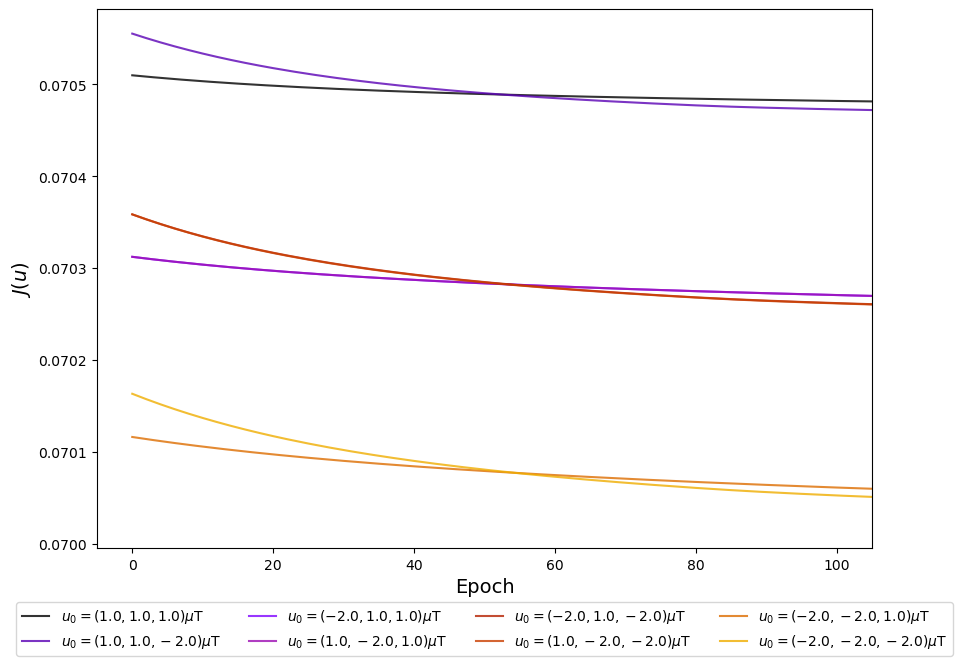

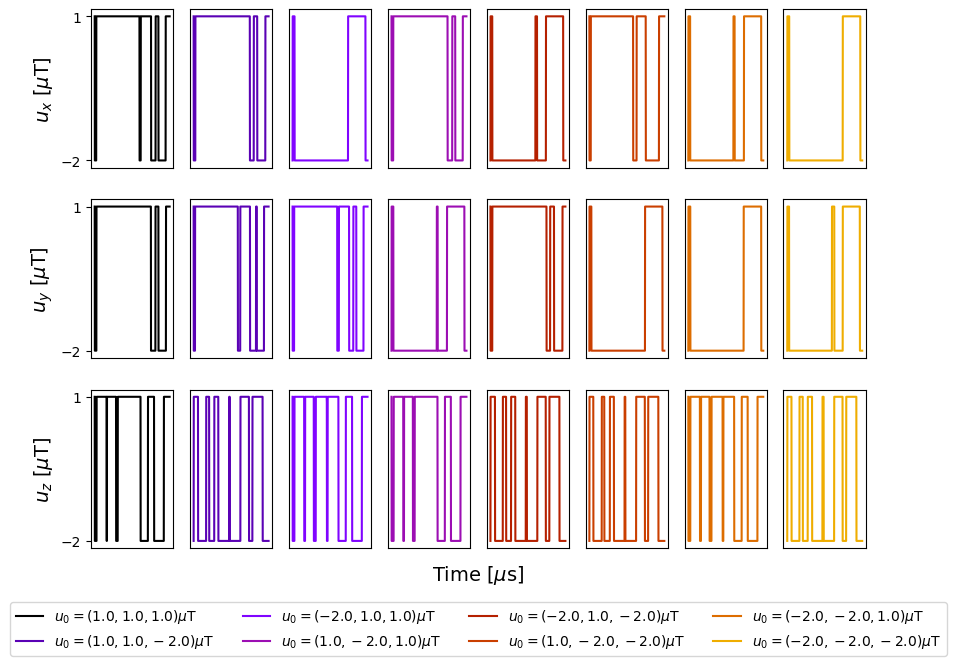

In [399]:
order = np.array([f[-1] for f in Js]).argsort()[::-1]
Js = np.array(Js)[order]
initials = np.array(initials)[order]
us = np.array(us)[order]
#colormap for initial field
colors = plt.cm.gnuplot(np.linspace(0,1,len(initials)+1))
fig_j =plt.figure(figsize=(10,7))
ax_j = fig_j.add_subplot(1,1,1)
[plt.plot(f,color=colors[i],alpha=0.8) for i,f in enumerate(Js)]
plt.legend([r'$u_0 = (%.1f,%.1f,%.1f) \mu$T'%(u[0]*1.e3,u[1]*1.e3,u[2]*1.e3) for u in initials],
           bbox_to_anchor=[0.5, -0.15],loc='center',ncols=4)
plt.xlim((-5,105))
plt.xlabel('Epoch',fontsize=14)
plt.ylabel(r'$J(u)$',fontsize=14)


#plt.savefig('results/bounds/%ihfi/J_all_initial_bb_%.0e_%.0e.pdf'%(H.n_nuclei,bounds[0],bounds[1]),bbox_inches='tight')
#plt.savefig('results/bounds/%ihfi/J_all_initial_bb_%.0e_%.0e.png'%(H.n_nuclei,bounds[0],bounds[1]),bbox_inches='tight')


fig_u = plt.figure(figsize=(10,7))
ax = fig_u.add_subplot(1,1,1)
plt.axis('off')
[plt.plot([-1,-1],color=colors[i]) for i in range(len(initials))]
plt.xlim((0,0.1))
plt.ylim((0,0.1))
plt.text(0.5,-0.05,r'Time [$\mu$s]',fontsize=14,transform=ax.transAxes,horizontalalignment='center',verticalalignment='center')

for i,u in enumerate(us):
    H.omega_t = u.copy()
    J,_,_,_ = gpm.field_optimization(5.e5,0.,2,tol,update_lr=0,bounds=bounds,maximize=triplet)
    ax_j.plot(len(Js[0])+1,J[-1],'p',color=colors[i],alpha=1)
    for j in range(3):
        fig_u.add_subplot(3,len(us),i+1+j*len(us))
        plt.plot(H.t/H.gamma_e,H.omega_t[:,j]*1.e3,color=colors[i])
        plt.xticks([])
        if i==0:
            plt.ylabel(r'$u_{%s}$ [$\mu$T]'%(['x','y','z'][j]),fontsize=14)
            plt.yticks(np.array(bounds)*1.e3)
        else:
            plt.yticks([])

ax.legend([r'$u_0 = (%.1f,%.1f,%.1f) \mu$T'%(u[0]*1.e3,u[1]*1.e3,u[2]*1.e3) for u in initials],
             bbox_to_anchor=[0.5, -0.15],loc='center',ncols=4)

#plt.savefig('results/bounds/%ihfi/u_all_initial_bb_%.0e_%.0e.pdf'%(H.n_nuclei,bounds[0],bounds[1]),bbox_inches='tight')
#plt.savefig('results/bounds/%ihfi/u_all_initial_bb_%.0e_%.0e.png'%(H.n_nuclei,bounds[0],bounds[1]),bbox_inches='tight')


## Linear connection between results

Epoch: 0/3, J: 1.78307779e-01, J2: 1.84268911e-02,d_x0: 6.3351e+06, Time: 9:19
Epoch: 0/3, J: 1.78306535e-01, J2: 1.84281349e-02,d_x0: 6.3351e+06, Time: 9:19
Epoch: 0/3, J: 1.78305267e-01, J2: 1.84294032e-02,d_x0: 6.3350e+06, Time: 9:20
Epoch: 0/3, J: 1.78303974e-01, J2: 1.84306961e-02,d_x0: 6.3350e+06, Time: 9:20
Epoch: 0/3, J: 1.78302657e-01, J2: 1.84320134e-02,d_x0: 6.3350e+06, Time: 9:20
Epoch: 0/3, J: 1.78301315e-01, J2: 1.84333553e-02,d_x0: 6.3350e+06, Time: 9:20
Epoch: 0/3, J: 1.78299949e-01, J2: 1.84347216e-02,d_x0: 6.3350e+06, Time: 9:20
Epoch: 0/3, J: 1.78298558e-01, J2: 1.84361124e-02,d_x0: 6.3350e+06, Time: 9:20
Epoch: 0/3, J: 1.78297143e-01, J2: 1.84375277e-02,d_x0: 6.3349e+06, Time: 9:20
Epoch: 0/3, J: 1.78295703e-01, J2: 1.84389674e-02,d_x0: 6.3349e+06, Time: 9:20
Epoch: 0/3, J: 1.78294239e-01, J2: 1.84404316e-02,d_x0: 6.3349e+06, Time: 9:20
Epoch: 0/3, J: 1.78292750e-01, J2: 1.84419203e-02,d_x0: 6.3349e+06, Time: 9:20
Epoch: 0/3, J: 1.78291237e-01, J2: 1.84434334e-02,d_

([<matplotlib.axis.XTick at 0x149ed8b10>,
 [Text(0, 0, 'GPM'), Text(1, 0, 'PMP')])

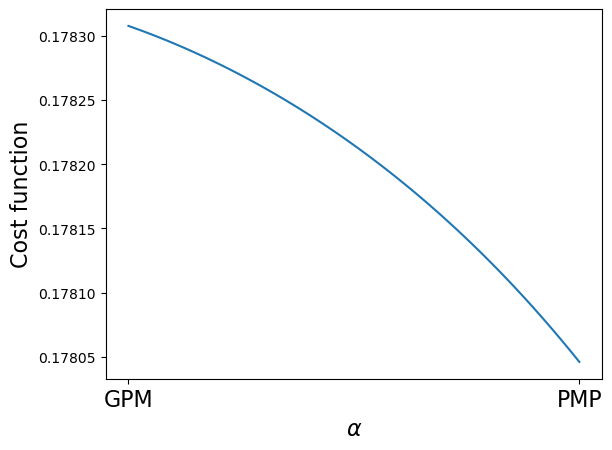

In [105]:
path = 'results/1P/Hyperfine/[-0.6,-0.3]' #Hyperfine 1P
file = os.path.join(path,'DATA/results_PMP/1P_MAX_T_1e-05_2000.mat')
mat = scipy.io.loadmat(file)
u_ =mat['sol_PMP'][0][0][-1][0][0][0][0][0].T
A_aux =mat['sol_PMP'][0][0][-1][0][0][1][0][0].T

A_ = H.A*0
A_[:,0,0,0] = A_aux[:,0]
A_[:,0,1,1] = A_aux[:,1]
A_[:,0,2,2] = A_aux[:,2]

A_gpm = np.load(os.path.join(path,'DATA/results_GPM_infty/inf_A_1p_A_optimization.npy'))
u_gpm = np.load(os.path.join(path,'DATA/results_GPM_infty/inf_u_1p_A_optimization.npy'))

A_gpm[A_gpm>-0.45]= -0.3
A_gpm[A_gpm<-0.45]= -0.6

j=[]
for alpha in np.linspace(0,1,101):
    H.omega_t = alpha*(u_)+(1-alpha)*u_gpm
    H.A = alpha*(A_) + (1-alpha)*A_gpm
    j.append(gpm.optimization((1.e-19,1.e-19),(0.,0.),3,tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)[0][-1])

plt.plot(np.linspace(0,1,101),j)
plt.xlabel(r'$\alpha$',fontsize=16)
plt.ylabel(r'Cost function',fontsize=16)
plt.xticks([0,1],['GPM','PMP'],fontsize=16)

In [101]:
path = 'results/1P/Hyperfine/[-0.6,-0.3]' #Hyperfine 1P
file = os.path.join(path,'DATA/results_PMP/1P_MAX_T_1e-05_2000.mat')
mat = scipy.io.loadmat(file)
u_pmp =mat['sol_PMP'][0][0][-1][0][0][0][0][0].T
A_aux =mat['sol_PMP'][0][0][-1][0][0][1][0][0].T

A_pmp = H.A*0
A_pmp[:,0,0,0] = A_aux[:,0]
A_pmp[:,0,1,1] = A_aux[:,1]
A_pmp[:,0,2,2] = A_aux[:,2]

A_gpm = np.load(os.path.join(path,'DATA/results_GPM_infty/inf_A_1p_A_optimization.npy'))
u_gpm = np.load(os.path.join(path,'DATA/results_GPM_infty/inf_u_1p_A_optimization.npy'))

A_gpm[A_gpm>-0.45]= -0.3
A_gpm[A_gpm<-0.45]= -0.6

s_pmp = [np.where(abs(np.diff(A_pmp[:,0,i,i]))>0.15)[0] for i in range(3)]
s_gpm = [np.where(abs(np.diff(A_gpm[:,0,i,i]))>0.15)[0] for i in range(3)]

def peaks(A):
    s = [np.where(abs(np.diff(A[:-1,0,i,i]))>0.15)[0] for i in range(3)]
    rs = [A[s[i][0],0,i,i]>-0.45 for i in range(3)]
    l0 = np.zeros((np.max([len(s[i]) for i in range(3)])+3,3))
    for i in range(3):
        c1 = int(rs[i])
        l0[c1:len(s[i])+c1,i] = H.t[s[i]]
        if c1:
            l0[0,i] = -100
        l0[len(s[i])+c1:,i] = 1000
    return l0

S = lambda t,t0: np.heaviside(t-t0,0.)
l_pmp = peaks(A_pmp)
l_gpm = peaks(A_gpm)
j=[]

for alpha in np.linspace(0,1,301):
    H.omega_t = u_pmp.copy()
    l0 = alpha*l_pmp + (1-alpha)*l_gpm
    print(l0[0,0])
    for i in range(3):
        H.A[:,0,i,i] = np.sum([S(H.t,l0[l,i])*(1-S(H.t,l0[l+1,i])) for l in range(0,len(l0),2)],axis=0)*(bounds_A[1]-bounds_A[0])+bounds_A[0]
    j.append(gpm.optimization((1.e-19,1.e-19),(0.,0.),3,tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)[0][-1])

29.597240408068036
Epoch: 0/3, J: 1.78307779e-01, J2: 1.84268911e-02,d_x0: 6.3351e+06, Time: 9:3
29.5978276549015378307779e-01, J2: 1.84268911e-02,d_x0: 0.0000e+00 Time: 9:3
Epoch: 0/3, J: 1.78307582e-01, J2: 1.84270881e-02,d_x0: 6.3351e+06, Time: 9:3
29.5984149017350278307582e-01, J2: 1.84270881e-02,d_x0: 0.0000e+00 Time: 9:3
Epoch: 0/3, J: 1.78307582e-01, J2: 1.84270881e-02,d_x0: 6.3351e+06, Time: 9:3
29.5990021485685168307582e-01, J2: 1.84270881e-02,d_x0: 0.0000e+00 Time: 9:3
Epoch: 0/3, J: 1.78307582e-01, J2: 1.84270881e-02,d_x0: 6.3351e+06, Time: 9:3
29.5995893954020178307582e-01, J2: 1.84270881e-02,d_x0: 0.0000e+00 Time: 9:3
Epoch: 0/3, J: 1.78307582e-01, J2: 1.84270881e-02,d_x0: 6.3351e+06, Time: 9:3
29.6001766422355.78307582e-01, J2: 1.84270881e-02,d_x0: 0.0000e+00 Time: 9:3
Epoch: 0/3, J: 1.78307582e-01, J2: 1.84270881e-02,d_x0: 6.3351e+06, Time: 9:3
29.6007638890689978307582e-01, J2: 1.84270881e-02,d_x0: 0.0000e+00 Time: 9:3
Epoch: 0/3, J: 1.78307582e-01, J2: 1.84270881e-02,d

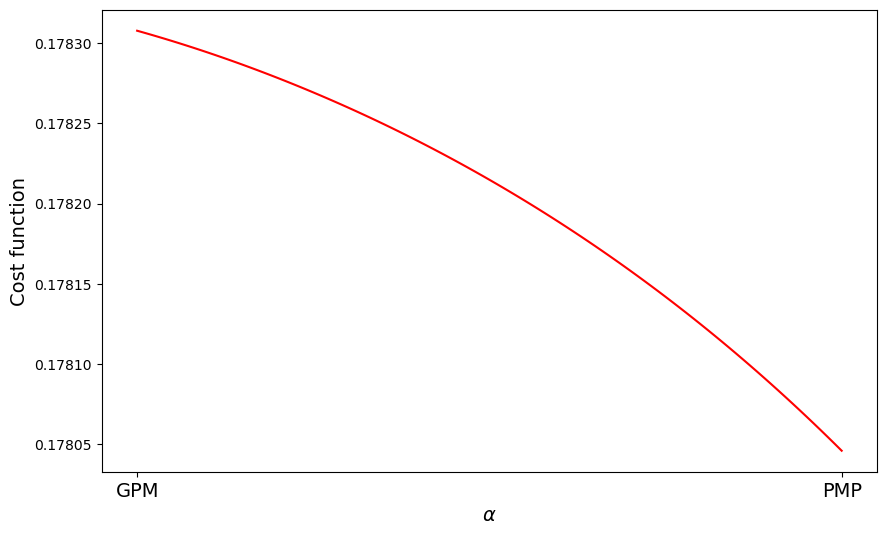

In [106]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,1,101),j,color='red')
plt.xlabel(r'$\alpha$',fontsize=14)
plt.ylabel(r'Cost function',fontsize=14)
plt.xticks([0,1],['GPM','PMP'],fontsize=14)
fig.savefig('linear_connection_2.pdf')

In [104]:
j=[]
for alpha in np.linspace(0,1,101):
    H.omega_t = alpha*(u_)+(1-alpha)*u_gpm
    H.A = alpha*(A_) + (1-alpha)*A_gpm
    j.append(gpm.optimization((1.e-19,1.e-19),(0.,0.),3,tol,update_lr=0,bounds=(bounds_u,bounds_A),maximize=True)[0][-1])

NameError: name 'u_' is not defined

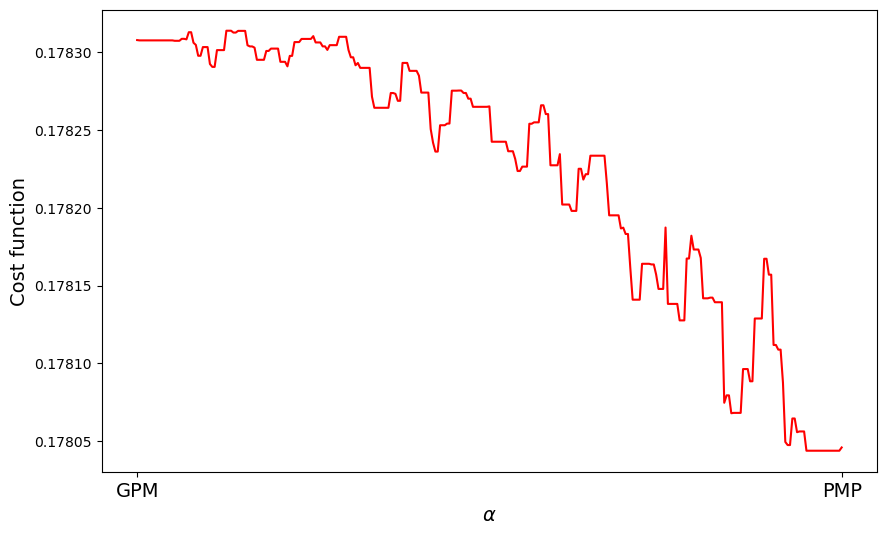

In [103]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,1,301),j,color='red')
plt.xlabel(r'$\alpha$',fontsize=14)
plt.ylabel(r'Cost function',fontsize=14)
plt.xticks([0,1],['GPM','PMP'],fontsize=14)
fig.savefig('linear_connection.pdf')

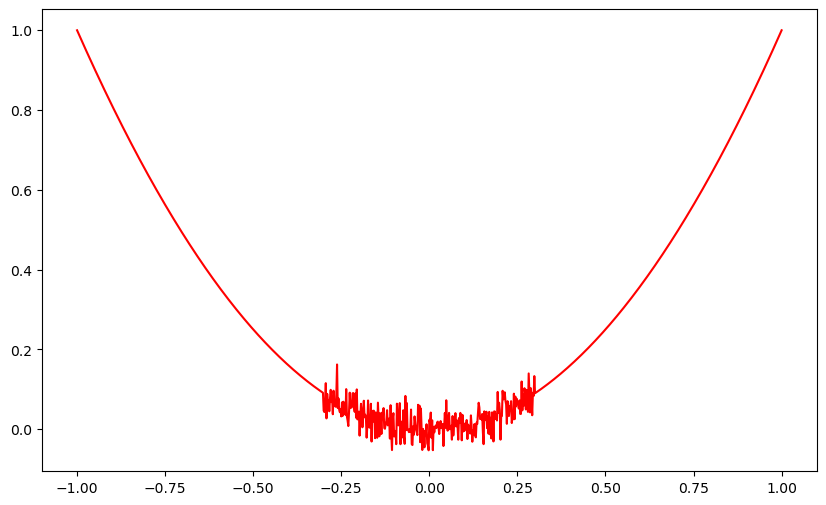

In [116]:
a= np.linspace(-1,1,1001)
b=a**2
b[350:650]+=np.random.normal(loc=0,scale=.03,size=300)
fig=plt.figure(figsize=(10,6))
plt.plot(a,b,color='red')
fig.savefig('aux.pdf')